<!-- Data Preparation -->

## Data Preparation

### 1. Import Libraries

In [786]:
import numpy as np     
import pandas as pd
import matplotlib.pyplot as plt   
import seaborn as sns   
%matplotlib inline  
sns.set()
import warnings  
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

### 2. Load the Data

In [787]:
data=pd.read_csv("Customer-Churn.csv")

In [788]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [789]:
data.shape

(7043, 21)

In [790]:
data.columns.to_list()

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [791]:
df=data

In [792]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [793]:
df['MonthlyCharges'].unique()

array([29.85, 56.95, 53.85, ..., 63.1 , 44.2 , 78.7 ])

### 3. Function helpers

#### 3.1 Check data

In [794]:
def data_info(data) :
    pd.set_option('display.max_rows',None)
    missing_values = data.isnull().sum()
    missing_perc = (missing_values/len(data))*100
    data_type = data.dtypes
    num_unique = data.nunique()

    print (f'Rows,Columns {data.shape}')
    print (f'Duplicated Values {data.duplicated().sum()}')
    print('=====\n')

    check_df = pd.DataFrame ({'missingValue' : missing_values,
                          'percentMissing' : missing_perc,
                          'DataType' : data_type,
                          'Unique' : num_unique}).sort_values('percentMissing',ascending=False)

    return check_df

#### 3.2 Check the outliers using statistical method

In [795]:
def outlier(df,column) :
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1 - (1.5*iqr)
    upper = q3 + (1.5*iqr)

    outlier_count = 0

    def check_outlier(x):
        nonlocal outlier_count
        if x < lower or x > upper:
            outlier_count += 1
            return 'outlier'
        else:
            return 'not-outlier'

    outlier_list = df[column].apply(check_outlier)
    print (f' outlier lower limit : {lower} \n outlier upper limit : {upper}')
    print(f'Number of outliers: {outlier_count}')

    # return outlier_list

In [796]:
def check_dependency (data, x, y) :

    obs_x = pd.crosstab(data[x],data[y])
    chi2, p, dof, expected = chi2_contingency(obs_x)
    alpha = 0.05

    print(f'=== V1: {x} === V2: {y} ===')


    if p<alpha :
        print (f'Chi-square Statistic : {chi2} \np-value: {p} < {alpha} \nV1 and V2 are dependent (significant association)')
        print()

    else :
        print (f'Chi-square Statistic : {chi2} \np-value: {p} > {alpha} \nV1 and V2 are independent (no significant association)')
        print()

In [797]:
def check_ttest (data, x) :
    churn_yes = data[data['Churn']==1][x]
    churn_no  = data[data['Churn']==0][x]

    alpha = 0.05
    t_stat_total , p_value = ttest_ind(churn_yes,churn_no)

    if p_value < alpha :
        print(x)
        print(f'p_value {p_value} < alpha {alpha}, t_stat_total = {t_stat_total}')
        print('There are significant differences between target and predictor\n')

    else :
        print(x)
        print(f'p_value {p_value} > alpha {alpha}, t_stat_total = {t_stat_total}')
        print('There are NO significant differences between target and predicto\n')

## 4. Model Evaluation

In [798]:
def train_eval (X, y, model) :
    model.fit(X, y)
    pred = model.predict(X)

    cm = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=model.classes_)

    print(f'Confusion Matrix : \n{cm}\n')
    print(f' Accuracy : {accuracy_score(y, pred)}')
    print(f' Recall Score : {recall_score(y, pred)}')
    print(f' Precision Score : {precision_score(y, pred)}')
    print(f' F1 Score : {f1_score(y, pred)}')
    print(f' ROC-AUC Score : {roc_auc_score(y,model.predict_proba(X)[:,1])}')
    print()
    cross_val_recall(X, y, model)

    disp.plot()
    

In [799]:
def test_eval (X, y, model) :
    pred = model.predict(X)

    cm = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=model.classes_)

    print(f'Confusion Matrix : \n{cm}\n')
    print(f' Accuracy : {accuracy_score(y, pred)}')
    print(f' Recall Score : {recall_score(y, pred)}')
    print(f' Precision Score : {precision_score(y, pred)}')
    print(f' F1 Score : {f1_score(y, pred)}')
    print(f' ROC-AUC Score : {roc_auc_score(y,model.predict_proba(X)[:,1])}')

    disp.plot()

In [800]:
def cross_val_recall (X, y, model) :
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  recall_scorer = make_scorer(recall_score)

  recall_scores = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer)

  print(" Recall scores for each fold:", recall_scores)
  print(" Average recall score:", recall_scores.mean())

In [801]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [802]:
data_info(df)

Rows,Columns (7043, 21)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
customerID,0,0.0,object,7043
DeviceProtection,0,0.0,object,3
TotalCharges,0,0.0,object,6531
MonthlyCharges,0,0.0,float64,1585
PaymentMethod,0,0.0,object,4
PaperlessBilling,0,0.0,object,2
Contract,0,0.0,object,3
StreamingMovies,0,0.0,object,3
StreamingTV,0,0.0,object,3
TechSupport,0,0.0,object,3


### Summary 1

     1. 7043 rows of data with 21 data variables
     2. No missing or duplicate values
     3. TotalCharges's data type needs to be changed due to the fact it's currently set to object. Since MonthlyCharges is float64, we                           assumethatTotalCharges is supposed to be float64 too.
     4. Churn data is currently string, decided to change to int for better predicting

## Data Preprocessing

In [803]:
# copy original file for safe keeping
df_ori = df.copy()

# turn TotalCharges from object to float64, making it same type as MonthlyCharges for easier processing
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# turn Churn target data to be int for predicting
df['Churn']= df['Churn'].replace(['No' ,'Yes'],[0,1])

In [804]:
data_info(df)

Rows,Columns (7043, 21)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
TotalCharges,11,0.156183,float64,6530
customerID,0,0.000000,object,7043
DeviceProtection,0,0.000000,object,3
MonthlyCharges,0,0.000000,float64,1585
PaymentMethod,0,0.000000,object,4
PaperlessBilling,0,0.000000,object,2
Contract,0,0.000000,object,3
StreamingMovies,0,0.000000,object,3
StreamingTV,0,0.000000,object,3
TechSupport,0,0.000000,object,3


## Summary 2

    1. There seems to be 11 missing data in TotalCharges.
    2. There is also 22 duplicated data, assuming due to the fact we changed TotalCharges data type.

##### Check missing valus

In [805]:
df[df['TotalCharges'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0


only 0.15% of data is null, we may delete the rows so that it doesn't effect out analysis later on

In [806]:
# drop rows where TotalCharges isNaN and do not create a new dataset
df = df[df['TotalCharges'].notna()].reset_index(drop=True)

In [807]:
data_info(df)

Rows,Columns (7032, 21)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
customerID,0,0.0,object,7032
DeviceProtection,0,0.0,object,3
TotalCharges,0,0.0,float64,6530
MonthlyCharges,0,0.0,float64,1584
PaymentMethod,0,0.0,object,4
PaperlessBilling,0,0.0,object,2
Contract,0,0.0,object,3
StreamingMovies,0,0.0,object,3
StreamingTV,0,0.0,object,3
TechSupport,0,0.0,object,3


In [808]:
#check each data for uniqueness
df_columns = df.columns.tolist()
for column in df_columns:
    print(f"{column} : {df[column].unique()}")
    print('\n')

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']


gender : ['Female' 'Male']


SeniorCitizen : [0 1]


Partner : ['Yes' 'No']


Dependents : ['No' 'Yes']


tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]


PhoneService : ['No' 'Yes']


MultipleLines : ['No phone service' 'No' 'Yes']


InternetService : ['DSL' 'Fiber optic' 'No']


OnlineSecurity : ['No' 'Yes' 'No internet service']


OnlineBackup : ['Yes' 'No' 'No internet service']


DeviceProtection : ['No' 'Yes' 'No internet service']


TechSupport : ['No' 'Yes' 'No internet service']


StreamingTV : ['No' 'Yes' 'No internet service']


StreamingMovies : ['No' 'Yes' 'No internet service']


Contract : ['Month-to-month' 'One year' 'Two year']


PaperlessBilling : ['Yes' 'No']


PaymentMethod : ['Electronic 

###  Summary 3

  1. A total of 11 (0.15%) data removed due to missing values.

In [809]:
new_df = df.copy()
df_ori = df.copy()

In [810]:
# Replace 'No' with 0 and 'Yes' with 1 in the 'PhoneService' column
new_df['PhoneService'] = new_df['PhoneService'].replace(['No' ,'Yes'],[0,1])

# Replace 'No' with 0, 'Yes' with 1, and 'No phone service' with 0 in the 'MultipleLines' column
new_df['MultipleLines'] = new_df['MultipleLines'].replace(['No' ,'Yes', 'No phone service'],[0, 1, 0])

# Replace 'No' with 0, 'Fiber optic' with 1, and 'DSL' with 0 in the 'InternetService' column
new_df['InternetService'] = new_df['InternetService'].replace({'No': 0, 'Fiber optic': 1, 'DSL': 1})

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'OnlineSecurity' column
new_df['OnlineSecurity'] = new_df['OnlineSecurity'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'OnlineBackup' column
new_df['OnlineBackup'] = new_df['OnlineBackup'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'DeviceProtection' column
new_df['DeviceProtection'] = new_df['DeviceProtection'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'TechSupport' column
new_df['TechSupport'] = new_df['TechSupport'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'StreamingTV' column
new_df['StreamingTV'] = new_df['StreamingTV'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'StreamingMovies' column
new_df['StreamingMovies'] = new_df['StreamingMovies'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

In [811]:
new_df['SubscribedServices'] = new_df[['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection']].sum(axis=1)
df['SubscribedServices'] = new_df[['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection']].sum(axis=1)


In [812]:
new_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SubscribedServices
0,7590-VHVEG,Female,0,Yes,No,1,0,0,1,0,...,0,0,0,Month-to-month,Yes,Electronic check,29.85,29.85,0,2
1,5575-GNVDE,Male,0,No,No,34,1,0,1,1,...,0,0,0,One year,No,Mailed check,56.95,1889.50,0,4
2,3668-QPYBK,Male,0,No,No,2,1,0,1,1,...,0,0,0,Month-to-month,Yes,Mailed check,53.85,108.15,1,4
3,7795-CFOCW,Male,0,No,No,45,0,0,1,1,...,1,0,0,One year,No,Bank transfer (automatic),42.30,1840.75,0,4
4,9237-HQITU,Female,0,No,No,2,1,0,1,0,...,0,0,0,Month-to-month,Yes,Electronic check,70.70,151.65,1,2


In [813]:
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SubscribedServices
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,2
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,4
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,4
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,4
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,2


In [814]:
data_info(new_df)

Rows,Columns (7032, 22)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
customerID,0,0.0,object,7032
gender,0,0.0,object,2
Churn,0,0.0,int64,2
TotalCharges,0,0.0,float64,6530
MonthlyCharges,0,0.0,float64,1584
PaymentMethod,0,0.0,object,4
PaperlessBilling,0,0.0,object,2
Contract,0,0.0,object,3
StreamingMovies,0,0.0,int64,2
StreamingTV,0,0.0,int64,2


### Summary 4:
   
   1. Conduct label encoding to PhoneService, MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and
      StreamingMovies for machine learning modelling.
   3. Conduct specific label encoding for No phone service and No internet service to 0 assuming that they do not subscribe to the certain service.
   4. Create a new column called SubscribedServices to count the amount of subscribed services of a customer.

## Exploratory Data Analysis

### 4. Descriptive Statistics

In [815]:
# group column names
numerical = ['SeniorCitizen','tenure','MonthlyCharges', 'TotalCharges','Churn']
categorical = ['gender','Partner', 'Dependents','PhoneService', 'MultipleLines',
               'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV','StreamingMovies', 'Contract', 'PaperlessBilling',
               'PaymentMethod']

customerDemographic = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
customerAccInfo = ['Contract', 'PaperlessBilling', 'PaymentMethod']
customerSpending = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [816]:
#numerical analysis
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80
Churn,7032.0,0.265785,0.441782,0.00,0.0000,0.000,1.0000,1.00


In [817]:
#categorical analysis
df[categorical].describe().T

,count,unique,top,freq
gender,7032,2,Male,3549
Partner,7032,2,No,3639
Dependents,7032,2,No,4933
PhoneService,7032,2,Yes,6352
MultipleLines,7032,3,No,3385
InternetService,7032,3,Fiber optic,3096
OnlineSecurity,7032,3,No,3497
OnlineBackup,7032,3,No,3087
DeviceProtection,7032,3,No,3094
TechSupport,7032,3,No,3472


##  Summary 4

   1. Churn and SeniorCitizen are features with boolean data type either 1 or 0. There is no need to further describe it.
   2. tenure and MonthlyCharges have distributions that tend to be symmetrical because the difference in mean and median values is less than 15%
   3. TotalCharges has an asymmetric distribution because it has a large difference between the mean and median values

## 5. Check Outliers & Distribution

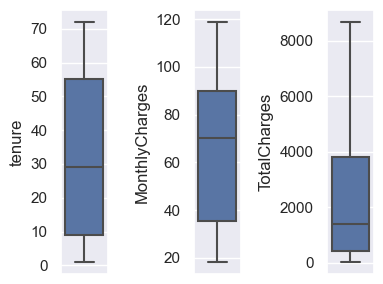

In [818]:
features = customerSpending
plt.figure(figsize=(4,3))
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y = df[features[i]])
    plt.tight_layout()

In [819]:
outlier(df, 'tenure')

 outlier lower limit : -60.0 
 outlier upper limit : 124.0
Number of outliers: 0


In [820]:
outlier(df, 'MonthlyCharges')

 outlier lower limit : -45.824999999999996 
 outlier upper limit : 171.27499999999998
Number of outliers: 0


In [821]:
outlier(df, 'TotalCharges')

 outlier lower limit : -4688.481250000001 
 outlier upper limit : 8884.66875
Number of outliers: 0


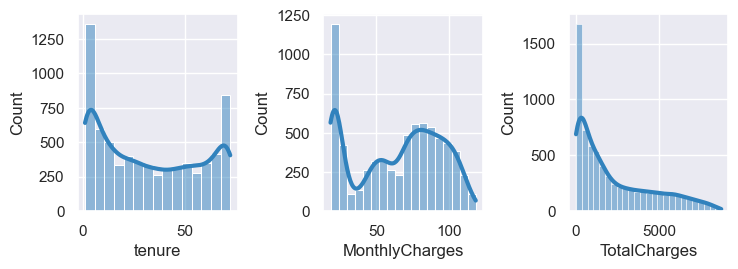

In [822]:
features = customerSpending
plt.figure(figsize=(10,5))
for i in range(0, len(features)):
  plt.subplot(2, 4, i+1)
  sns.histplot(x=df[features[i]], hue = i, palette = "tab20c", legend=False, kde=True, line_kws={'linewidth': 3})
  plt.xlabel(features[i])
  plt.tight_layout()

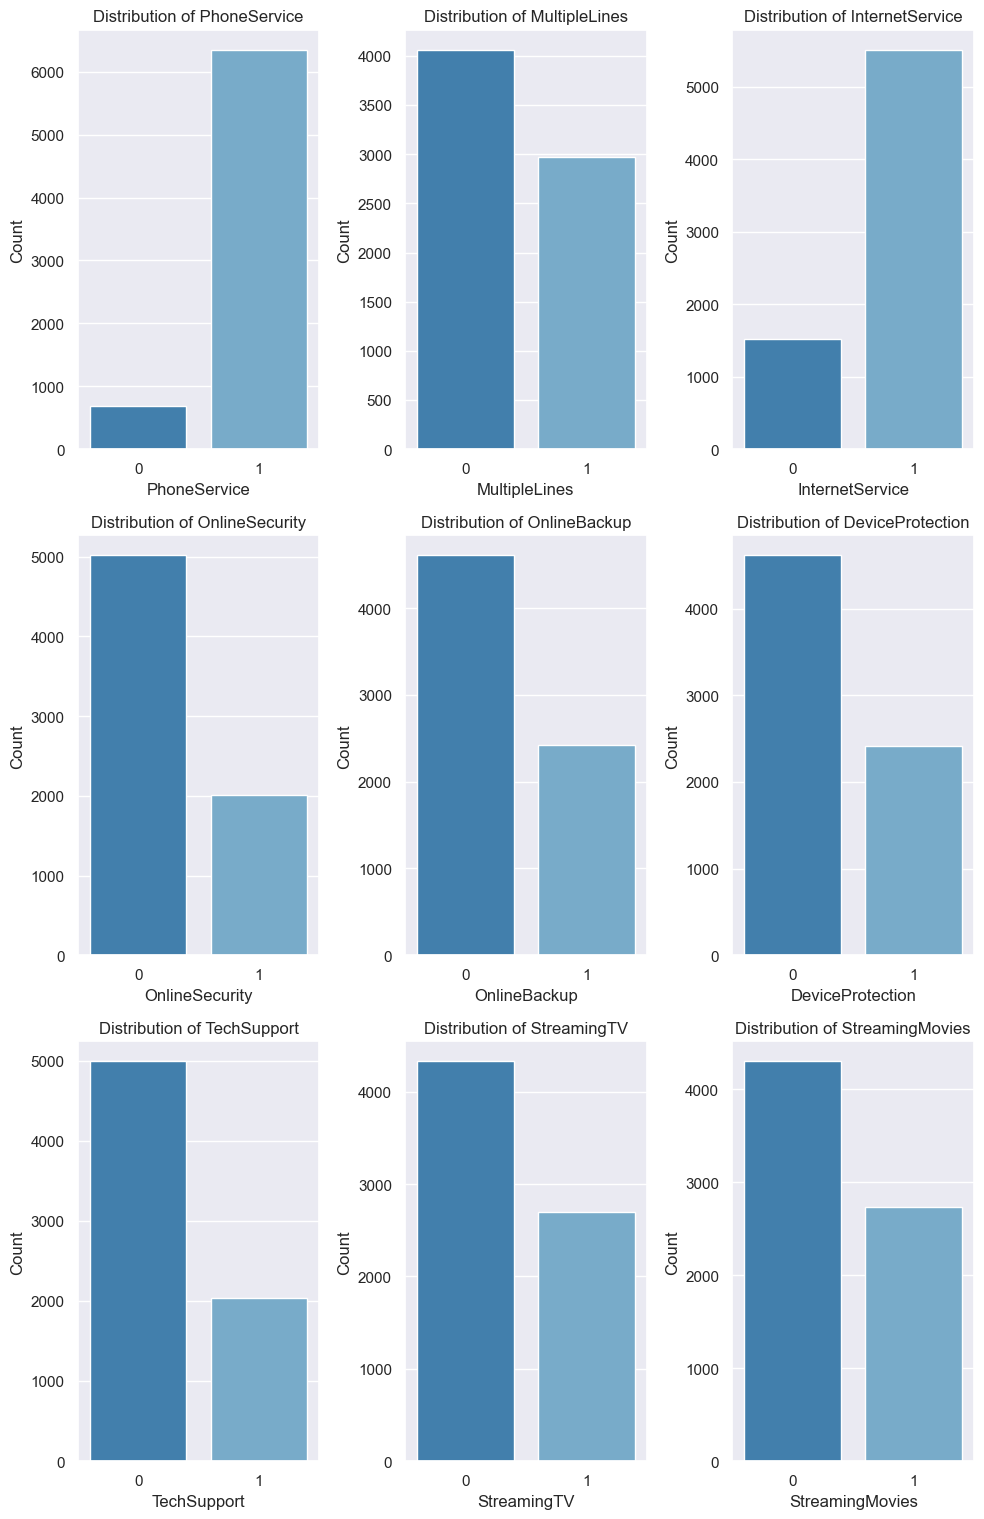

In [823]:

num_rows = len(services) // 2 + len(services) % 2
plt.figure(figsize=(10, 5 * num_rows))

for i, col in enumerate(services,start=1):
    plt.subplot(num_rows, 3, i)
    sns.countplot(x=col,  data=new_df, palette = "tab20c")
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend([], frameon=False)

plt.tight_layout()
plt.show()


### Summary 5
    1. There are no outliers in either tenure, MonthlyCharges or TotalCharges which can be stated that data is distributed evenly.
    2. Most customers are (at distribution peak): 
     ~ 4 tenure 
     ~ 10 MonthlyCharges
     ~ 357 TotalCharges
    3. tenure and MonthlyCharges both have bimodal skew which means there may be a gap in feature pricing (that customer may or may not subscribe to) that may impact customer's churn rate.
    4. TotalCharges is positively skewd which means that most of the customers in this dataset tend to prefer smaller packages or not subscribing to lots of features.
    5. Based on the distribution, InternetService may provide a deep insight on why customers may churn, since it's upselling packages like OnlineSecurity, TechSupport etc may correlate to InternetService.

## 6. Multivariate Analysis

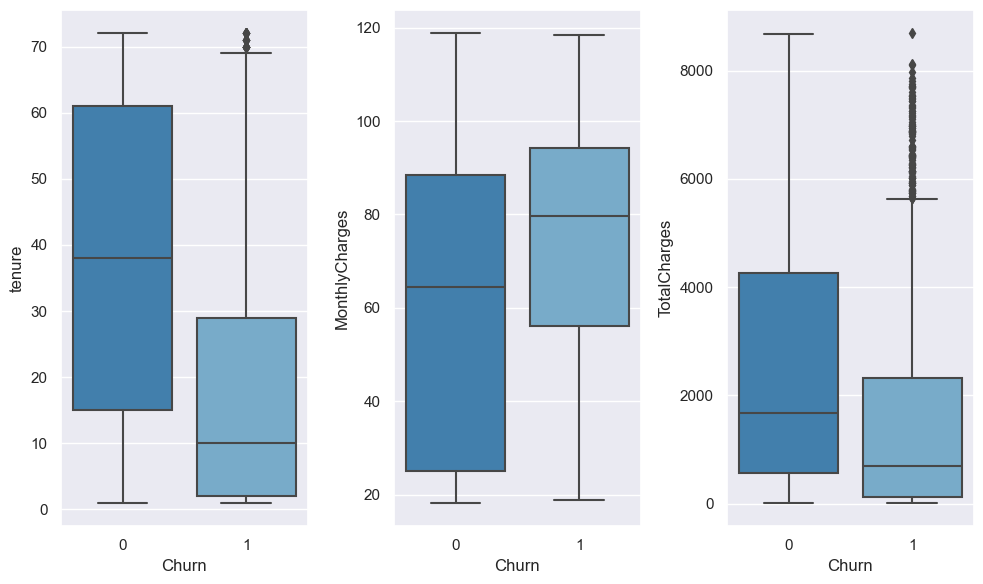

In [824]:
plt.figure(figsize=(10,6))

for x in range(0, len(customerSpending)):
    plt.subplot(1, len(customerSpending), x+1)
    sns.boxplot(x=new_df['Churn'],y=new_df[customerSpending[x]], palette = "tab20c")
    plt.tight_layout()


In [825]:
new_df[(new_df['TotalCharges']>=5800)&(new_df['Churn']==1)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SubscribedServices
104,3192-NQECA,Male,0,Yes,No,68,1,1,1,0,...,1,1,1,Two year,Yes,Bank transfer (automatic),110.00,7611.85,1,8
339,1343-EHPYB,Male,0,Yes,No,63,1,1,1,0,...,0,1,1,Month-to-month,Yes,Electronic check,103.40,6603.00,1,7
402,0979-PHULV,Male,0,Yes,Yes,69,1,1,1,0,...,0,1,1,Month-to-month,Yes,Credit card (automatic),99.45,7007.60,1,6
445,7752-XUSCI,Female,0,No,No,60,1,1,1,0,...,0,1,1,Month-to-month,Yes,Electronic check,105.90,6396.45,1,7
608,3419-SNJJD,Female,1,Yes,No,65,1,1,1,1,...,0,1,1,Month-to-month,No,Bank transfer (automatic),105.25,6786.40,1,7
634,7207-RMRDB,Female,0,Yes,Yes,65,1,1,1,0,...,0,1,1,Month-to-month,Yes,Electronic check,105.50,6985.65,1,7
797,3009-JWMPU,Male,0,No,No,62,1,1,1,0,...,0,1,1,One year,Yes,Electronic check,96.75,6125.40,1,6
808,2239-JALAW,Male,0,No,No,58,1,1,1,0,...,0,1,1,One year,Yes,Bank transfer (automatic),103.25,6017.65,1,7
809,4853-RULSV,Male,0,No,No,70,1,1,1,1,...,1,1,1,Two year,Yes,Credit card (automatic),104.00,7250.15,1,7
853,2382-BCKQJ,Female,0,No,Yes,62,1,1,1,0,...,0,1,1,One year,Yes,Electronic check,100.15,6413.65,1,6


In [826]:
new_df[(new_df['tenure']>=69)&(new_df['Churn']==1)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SubscribedServices
402,0979-PHULV,Male,0,Yes,Yes,69,1,1,1,0,...,0,1,1,Month-to-month,Yes,Credit card (automatic),99.45,7007.60,1,6
809,4853-RULSV,Male,0,No,No,70,1,1,1,1,...,1,1,1,Two year,Yes,Credit card (automatic),104.00,7250.15,1,7
972,2834-JRTUA,Male,0,No,No,71,1,1,1,1,...,1,1,1,Two year,Yes,Electronic check,108.05,7532.15,1,8
1302,0201-OAMXR,Female,0,No,No,70,1,1,1,1,...,1,1,1,One year,No,Credit card (automatic),115.55,8127.60,1,9
1962,0565-IYCGT,Male,0,No,No,69,1,1,1,1,...,1,0,1,One year,Yes,Credit card (automatic),78.60,5356.45,1,8
2282,5440-FLBQG,Male,1,Yes,No,69,1,1,1,0,...,1,1,1,Two year,Yes,Bank transfer (automatic),108.40,7318.20,1,8
2874,4550-VBOFE,Male,1,Yes,No,70,1,1,1,0,...,0,1,1,Month-to-month,Yes,Electronic check,102.95,7101.50,1,7
2992,1891-FZYSA,Male,1,Yes,No,69,1,1,1,0,...,0,1,0,Month-to-month,Yes,Electronic check,89.95,6143.15,1,5
3035,7317-GGVPB,Male,0,Yes,No,71,1,1,1,0,...,1,1,1,Two year,Yes,Credit card (automatic),108.60,7690.90,1,8
3106,8809-RIHDD,Male,0,Yes,Yes,72,1,1,1,0,...,0,1,1,Two year,Yes,Electronic check,103.40,7372.65,1,7


### Observation¶
   1. During plotting boxplot for tenure & TotalChanges alone there seems to be no outliers, but comparing it with Churn turns out there are outliers where Churun = 1
   2. Outliers will be kept for further analysis because they provide data where they include high paying customers which include InternetService Fiber Optic, OnlineSecurity, etc, and they tend to stick around for a long tenure period.

####  6.1 Customer Demographic Analysis

In [827]:
 def predictor_target(data,pred, tgt='Churn'):
    data[pred] = data[pred].astype(str)
    data[tgt] = data[tgt].astype(int)
    service_churn_rate = data.groupby(pred)[tgt].value_counts(normalize=True).unstack().fillna(0) * 100
    service_churn_rate = service_churn_rate.reset_index().melt(id_vars=pred, value_vars=[0, 1], var_name='Churn', value_name='ChurnRate')
    service_churn_rate['Churn'] = service_churn_rate['Churn'].astype(str)
    data[tgt] = data[tgt].astype(int)
    ax = sns.barplot(x=pred,y='ChurnRate',hue="Churn",data=service_churn_rate,palette="tab20c")
   
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height / 2.), ha='center', va='center', fontsize=10, color='black')

    plt.title(f'Churn Rate (%) of {pred}')
    plt.xlabel(pred)
    plt.ylabel('Churn Rate')
    plt.ylim(0,100)
    ax.legend(title='Churn', frameon=False)


In [828]:

def pred_tgt_list(data, features, columns=1, width=10, height=5):
  num_rows = len(features) // 2 + len(features) % 2
  plt.figure(figsize=(width, height * num_rows))

  for i, col in enumerate(features, start=1):
      plt.subplot(num_rows, columns, i)
      predictor_target(data, col)
      

  plt.tight_layout()
  plt.show()

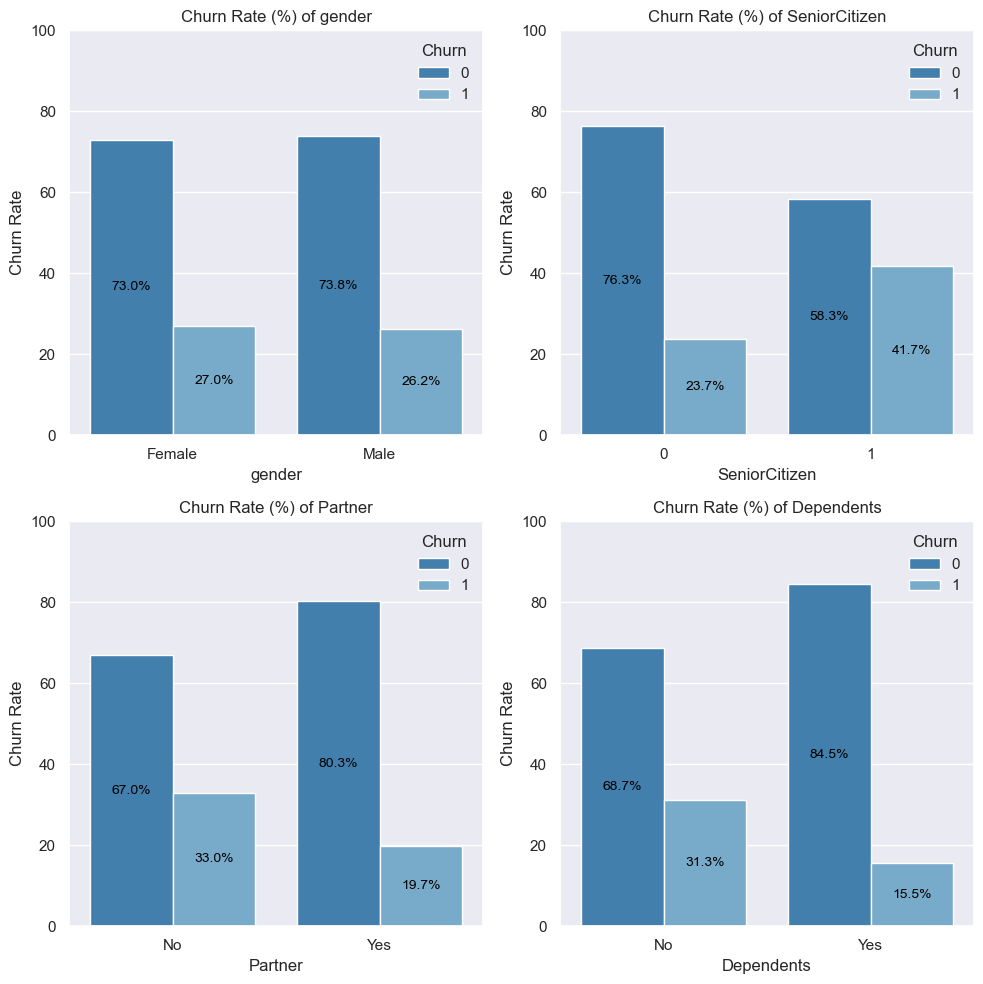

In [829]:
pred_tgt_list(new_df, customerDemographic,columns=2)


In [830]:
for x in  customerDemographic :
    check_dependency(new_df, x,'Churn')

=== V1: gender === V2: Churn ===
Chi-square Statistic : 0.47545453727386294 
p-value: 0.4904884707065509 > 0.05 
V1 and V2 are independent (no significant association)

=== V1: SeniorCitizen === V2: Churn ===
Chi-square Statistic : 158.4408162893713 
p-value: 2.4792557203954705e-36 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: Partner === V2: Churn ===
Chi-square Statistic : 157.50315146557506 
p-value: 3.97379757451591e-36 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: Dependents === V2: Churn ===
Chi-square Statistic : 186.32163933855873 
p-value: 2.0196592017051303e-42 < 0.05 
V1 and V2 are dependent (significant association)



### Summary 6.1

   1. gender does not correlate to Churn while SeniorCitizen, Partner, and Dependents do correlate.
   2. Customers that are senior citizens do tend to churn.
   3. Customers that have no partner (either single, divorced, deceassed, etc) and have no dependents do tend to churn.

### 6.2 Telco Services Analysis

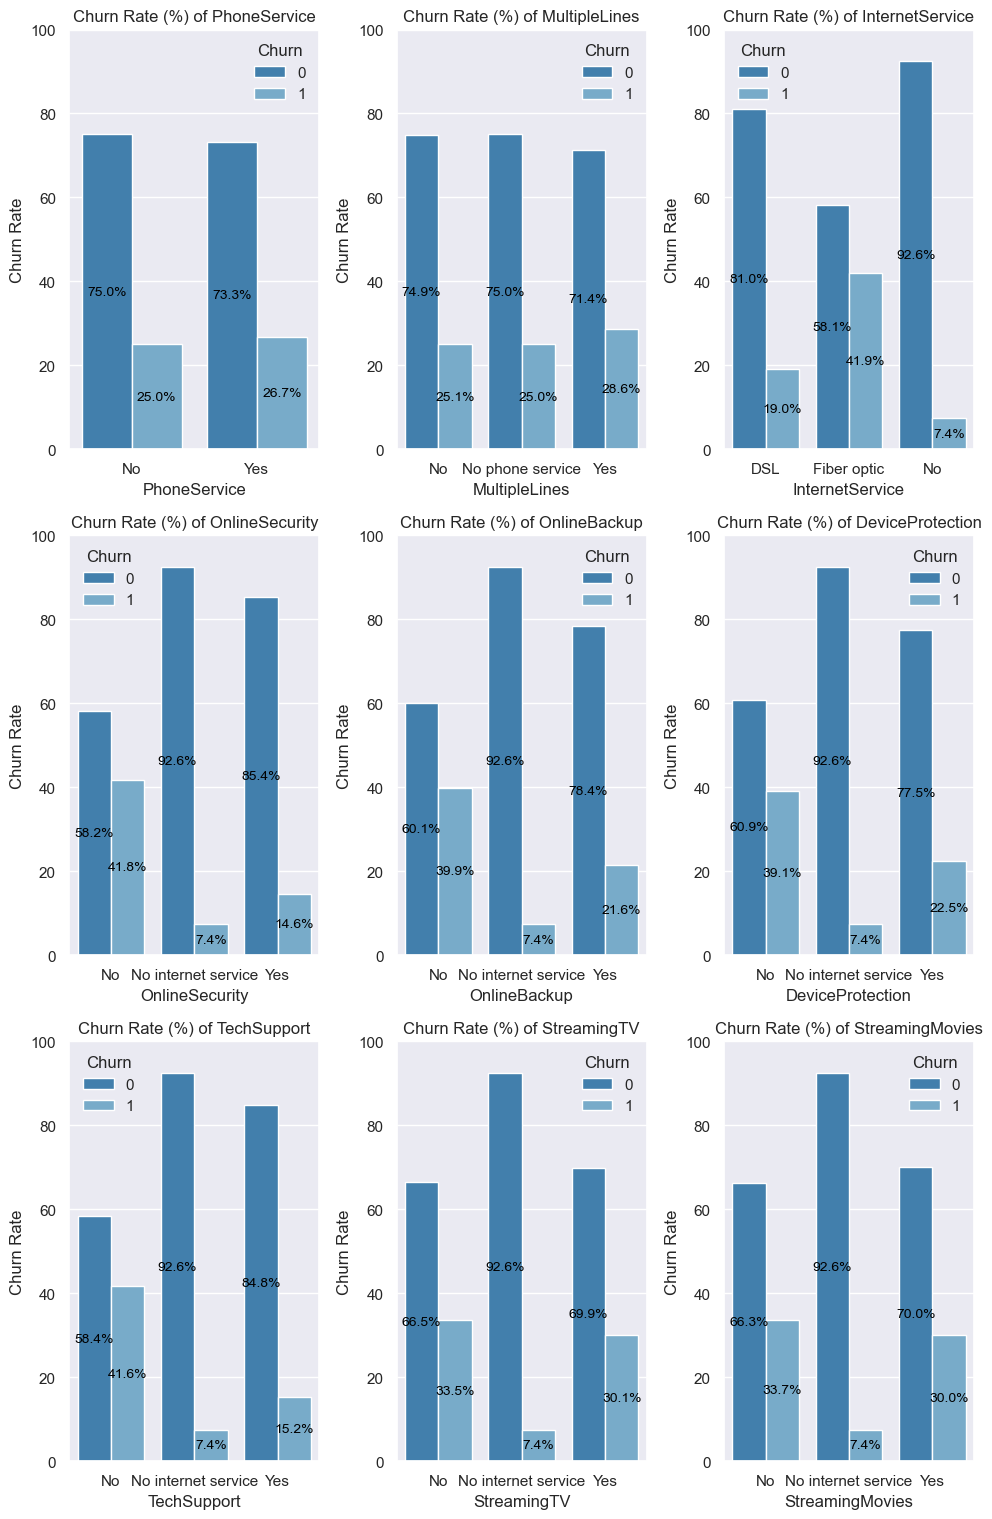

In [831]:
 pred_tgt_list(df,services,3)


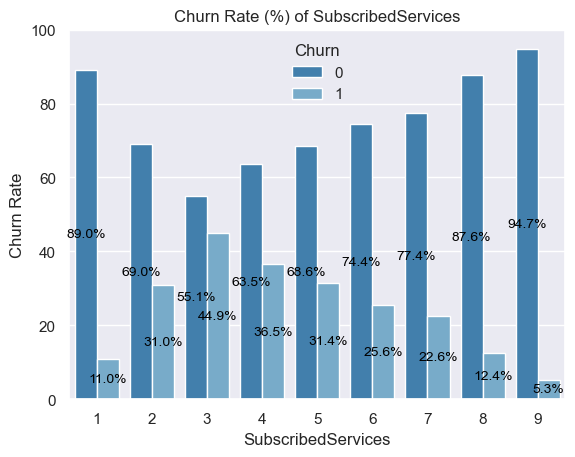

In [832]:
predictor_target(new_df, 'SubscribedServices')
plt.show()

In [833]:
for x in services :
    check_dependency(new_df, x,'Churn')

=== V1: PhoneService === V2: Churn ===
Chi-square Statistic : 0.8737327674431736 
p-value: 0.34992398942431924 > 0.05 
V1 and V2 are independent (no significant association)

=== V1: MultipleLines === V2: Churn ===
Chi-square Statistic : 11.08687591455858 
p-value: 0.0008694082815826175 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: InternetService === V2: Churn ===
Chi-square Statistic : 362.94784884289265 
p-value: 6.4225207979072035e-81 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: OnlineSecurity === V2: Churn ===
Chi-square Statistic : 205.41578737378245 
p-value: 1.37424000884718e-46 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: OnlineBackup === V2: Churn ===
Chi-square Statistic : 47.246659325881964 
p-value: 6.259257129714726e-12 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: DeviceProtection === V2: Churn ===
Chi-square Statistic : 30.49569910229676 
p-value: 3.346074945648779e-08 < 0.05 
V1 and V

### Summary 6.2:

  1. PhoneService has no correlation to Churn.
  2. Customers that subscribe to MultipleLines tend to churn.
  3. Customers that subscribe to an InternetService tend to churn, especially the ones subscribed to Fiber Optic. It has a higher chance of churn than the other options.
  4. Customer that subscribed to an InternetService that do not use protection nor support like OnlineSecurity, TechSupport, OnlineBackup, DeviceProtection tend to more likely churn.
  5. The more SubscribedServices by a customer, the less likely the tend to churn.

### 6.3 Customer Account Info Analysis

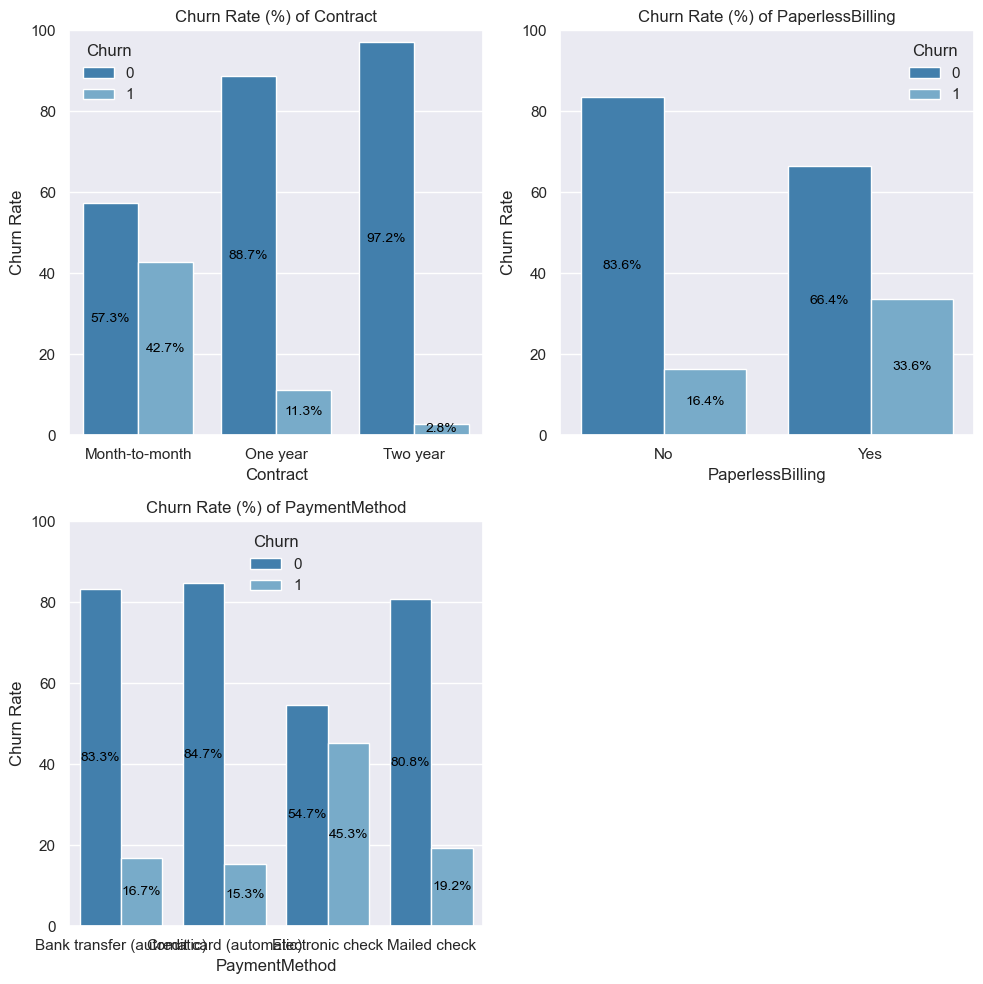

In [834]:
pred_tgt_list(df, customerAccInfo, 2, 10, 5)

In [835]:
for i in customerAccInfo :
    check_dependency(new_df, i,'Churn')


=== V1: Contract === V2: Churn ===
Chi-square Statistic : 1179.5458287339445 
p-value: 7.326182186265472e-257 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: PaperlessBilling === V2: Churn ===
Chi-square Statistic : 256.87490836218717 
p-value: 8.236203353962564e-58 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: PaymentMethod === V2: Churn ===
Chi-square Statistic : 645.4299001234638 
p-value: 1.4263098511063342e-139 < 0.05 
V1 and V2 are dependent (significant association)



#### Summary 6.3

   1. Customers with month-to-month Contract, with PaperlessBilling and using electronick check PaymentMethod tend to churn.

### 6.4 Customer Spending Analysis

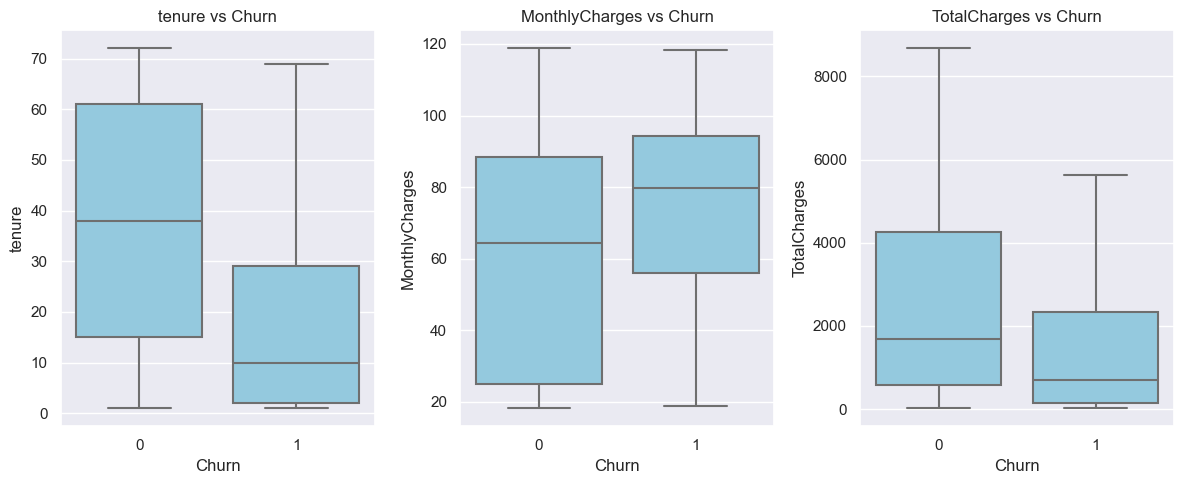

In [836]:
plt.figure(figsize=(12,5))

for i in range(0, len(customerSpending)):
    plt.subplot(1, len(customerSpending), i+1)
    sns.boxplot(x=new_df['Churn'],y=new_df[customerSpending[i]], color='skyblue',showfliers=False)
    plt.title(f'{customerSpending[i]} vs Churn')
    plt.tight_layout()

In [837]:
def predictor_target_num(data_frame, pred, tgt='Churn'):
  churn_rate = data_frame.groupby(tgt)[pred].mean().reset_index()
  ax = sns.barplot(x=tgt, y=pred, data=churn_rate, color='skyblue')

  for p in ax.patches:
      height = p.get_height()
      ax.annotate(f'{height:.1f}',
                  (p.get_x() + p.get_width() / 2., height / 2.),
                  ha='center', va='center',
                  fontsize=10, color='black')

  ax.set_ylabel('Churn Rate')
  ax.set_title(f'Churn Rate by Average {pred}')

  plt.show()

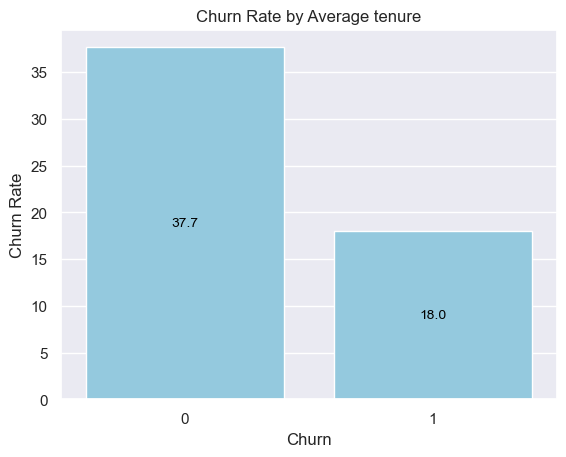

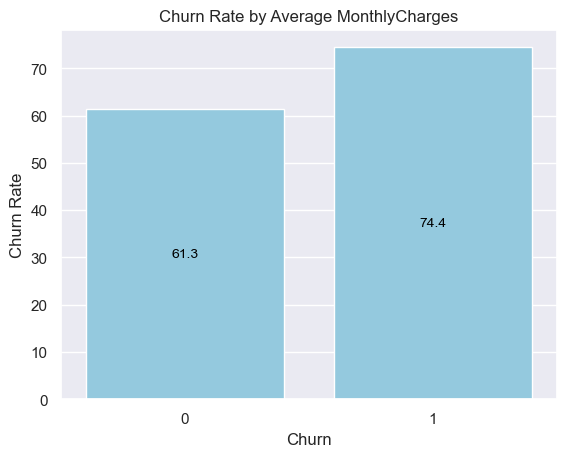

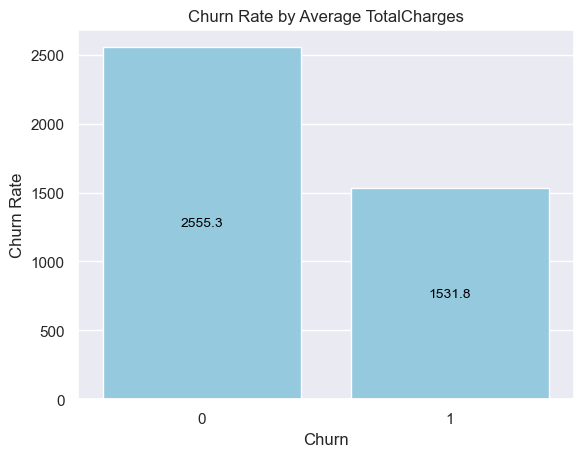

In [838]:
for i in customerSpending:
  predictor_target_num(new_df, i)

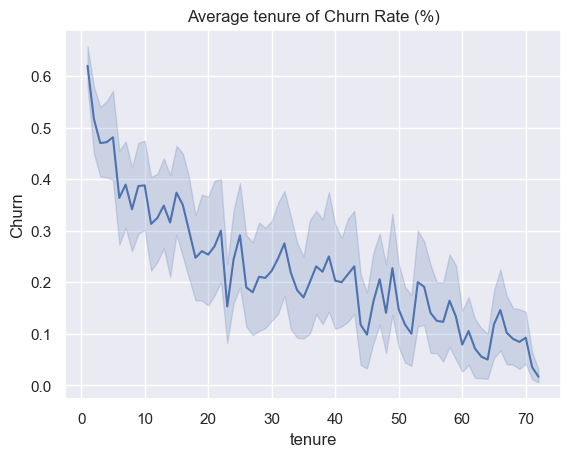

In [839]:
churn_rate = new_df.groupby('Churn')['tenure'].mean().reset_index()
sns.lineplot(x='tenure', y='Churn', data=new_df)

plt.title('Average tenure of Churn Rate (%)')
plt.show()

In [840]:
for i in customerSpending :
    check_ttest(new_df, i)

tenure
p_value 9.437650217574845e-207 < alpha 0.05, t_stat_total = -31.741289063447653
There are significant differences between target and predictor

MonthlyCharges
p_value 6.760843117980302e-60 < alpha 0.05, t_stat_total = 16.47959313114872
There are significant differences between target and predictor

TotalCharges
p_value 4.876865689694505e-64 < alpha 0.05, t_stat_total = -17.068827211220274
There are significant differences between target and predictor



#### Summary 6.4

   1. Customers with low tenure tend to churn.
   2. Customers that tend to churn have higher MonthlyCharges than those who do not churn.

## 7. Deep Dive Questions

#### 7.1 How does price effect customer's churn rate?

In [841]:
# define function to check mean of certain service based on MonthlyCharges
def avg_service_price(data_frame, service_column, charges_column='MonthlyCharges'):
    new_col_name = f'{service_column}-Charges'
    grouped_df = data_frame.groupby(service_column).agg(average_charges=(charges_column, 'mean')).reset_index()
    grouped_df = grouped_df.rename(columns={service_column: 'Service', 'average_charges': new_col_name})
    
    return grouped_df

In [842]:
df_1 = avg_service_price(df, 'InternetService')
df_1

,Service,InternetService-Charges
0,DSL,58.088017
1,Fiber optic,91.500129
2,No,21.076283


In [843]:
# since we want to know the price of internetService, we exclude "No" due to the fact it does not contain any InternetService
df_1 = df_1[df_1['Service']!='No']
df_1 = df_1.replace(['DSL','Fiber optic'],[0,1])
df_1

,Service,InternetService-Charges
0,0,58.088017
1,1,91.500129


In [844]:
df_2 = avg_service_price(new_df, 'MultipleLines')
df_2

,Service,MultipleLines-Charges
0,0,52.180935
1,1,82.084766


In [845]:
df_3 = avg_service_price(new_df, 'OnlineSecurity')
df_3

,Service,OnlineSecurity-Charges
0,0,59.146293
1,1,78.870496


In [846]:
df_4 = avg_service_price(new_df, 'OnlineBackup')
df_4

,Service,OnlineBackup-Charges
0,0,55.161265
1,1,83.106412


In [847]:
df_5 = avg_service_price(new_df, 'DeviceProtection')
df_5

,Service,DeviceProtection-Charges
0,0,54.287885
1,1,84.853888


In [848]:
df_6 = avg_service_price(new_df, 'TechSupport')
df_6

,Service,TechSupport-Charges
0,0,58.292198
1,1,80.718799


In [849]:
df_7 = avg_service_price(new_df, 'StreamingTV')
df_7

,Service,StreamingTV-Charges
0,0,49.829857
1,1,88.770829


In [850]:
df_8 = avg_service_price(new_df, 'StreamingMovies')
df_8

,Service,StreamingMovies-Charges
0,0,49.761962
1,1,88.478506


In [851]:
from functools import reduce

In [852]:
df_total_service = [df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8]

df_avg_service = reduce(lambda  left,right: pd.merge(left,right,on=['Service'],
                                            how='outer'), df_total_service)
df_avg_service

,Service,InternetService-Charges,MultipleLines-Charges,OnlineSecurity-Charges,OnlineBackup-Charges,DeviceProtection-Charges,TechSupport-Charges,StreamingTV-Charges,StreamingMovies-Charges
0,0,58.088017,52.180935,59.146293,55.161265,54.287885,58.292198,49.829857,49.761962
1,1,91.500129,82.084766,78.870496,83.106412,84.853888,80.718799,88.770829,88.478506


In [853]:
df_avg_service = df_avg_service.drop('Service',axis=1)

Text(0, 0.5, 'Ave Monthly Charges')

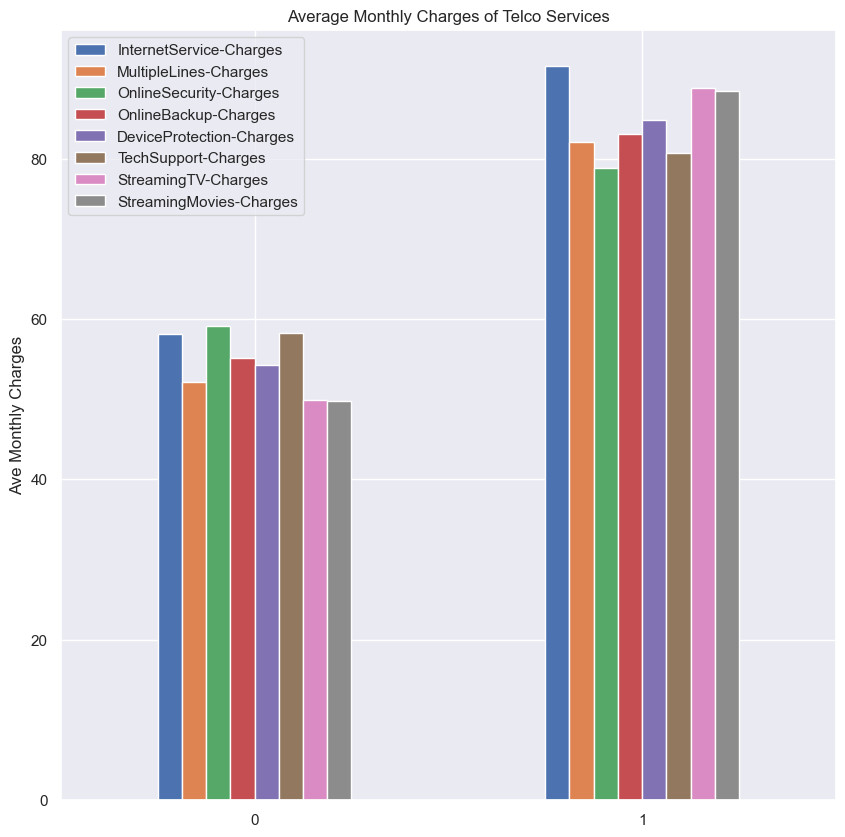

In [854]:
df_avg_service.plot(kind='bar',figsize=(10,10))
plt.title('Average Monthly Charges of Telco Services')
plt.xticks(rotation=0)
plt.ylabel('Ave Monthly Charges')

In [855]:
def plot_boxplot(hue_column, data=new_df, x_axis='SubscribedServices', y_axis='MonthlyCharges'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x=x_axis, y=y_axis, hue=hue_column, showfliers=False)
    
    plt.ylabel(y_axis)
    plt.title(f'Distribution of {y_axis} by {hue_column} in {x_axis}', fontsize=16)
    plt.show()

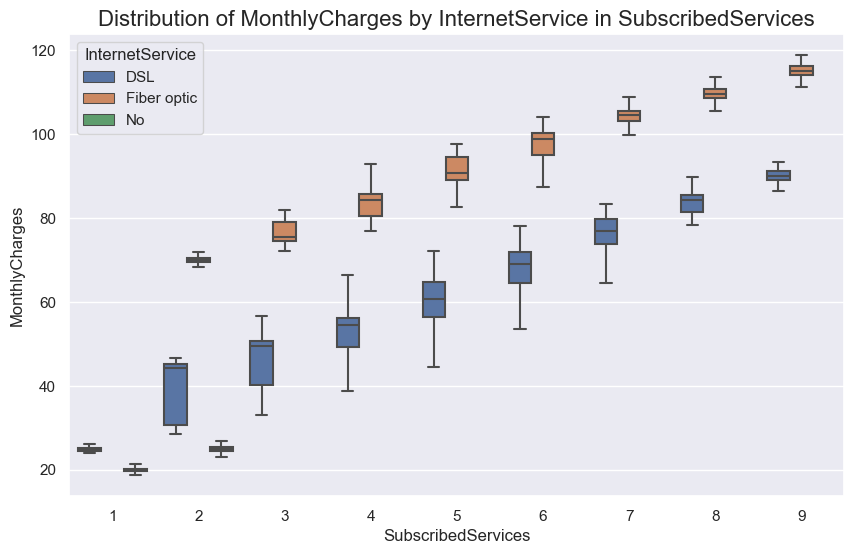

In [856]:
plot_boxplot('InternetService', df)

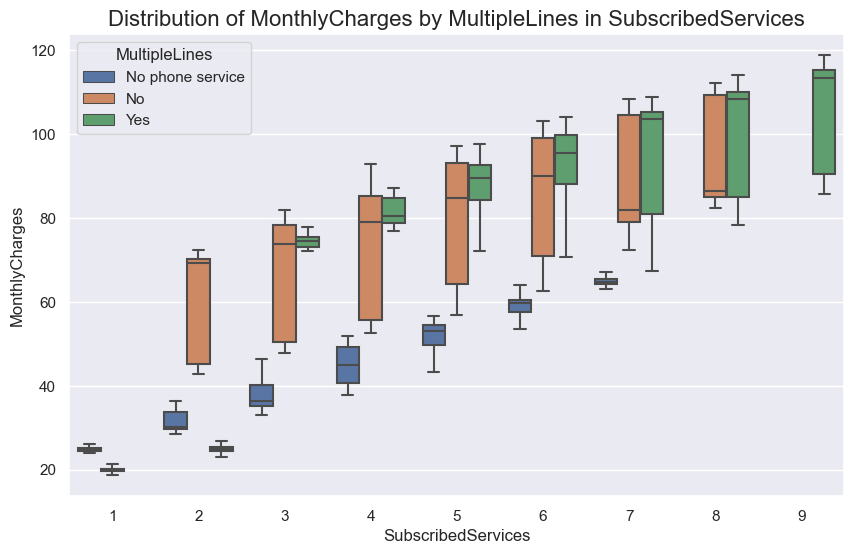

In [857]:
plot_boxplot('MultipleLines', df)

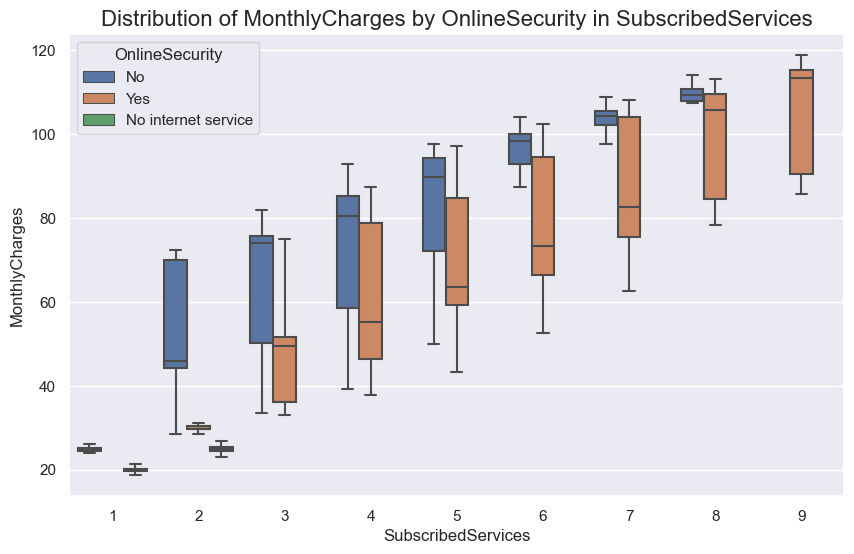

In [858]:
plot_boxplot('OnlineSecurity', df)

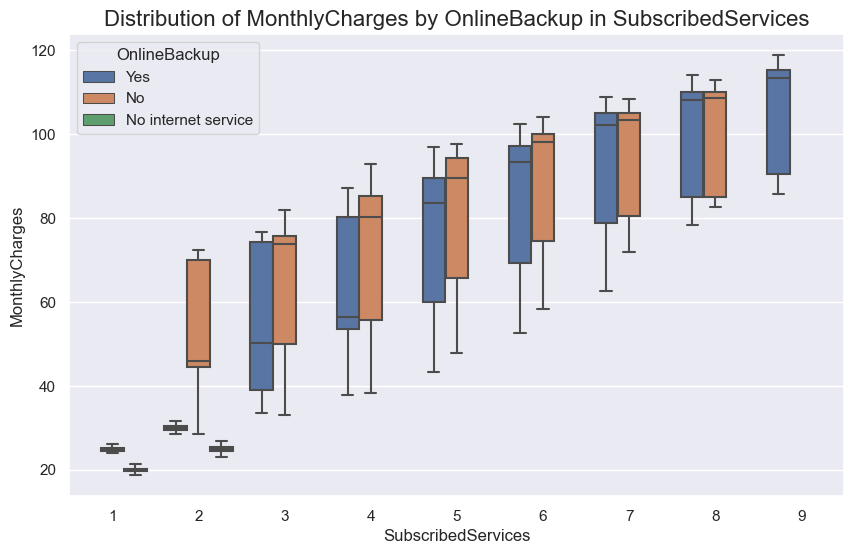

In [859]:
plot_boxplot('OnlineBackup', df)

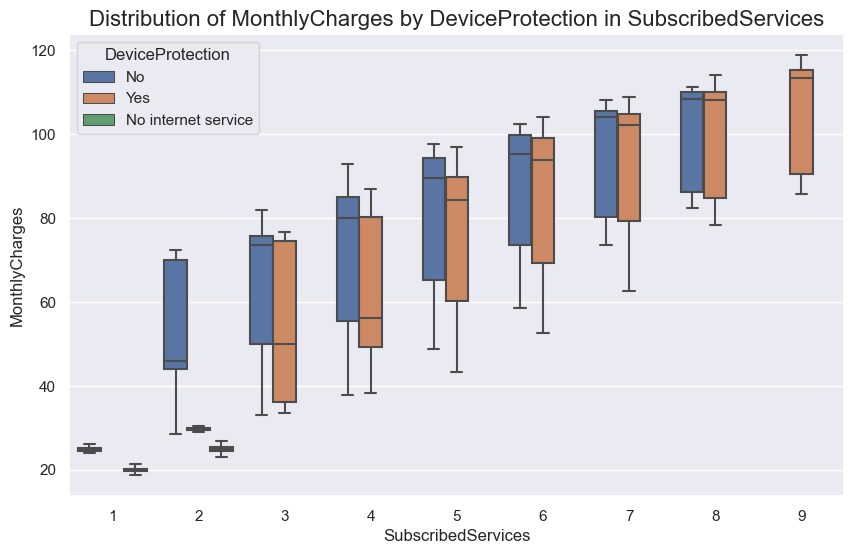

In [860]:
plot_boxplot('DeviceProtection', df)

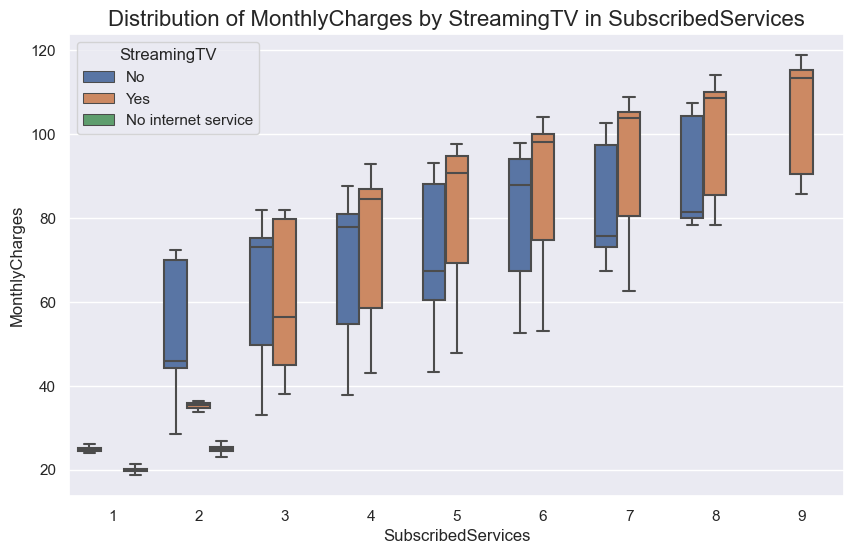

In [861]:
plot_boxplot('StreamingTV', df)

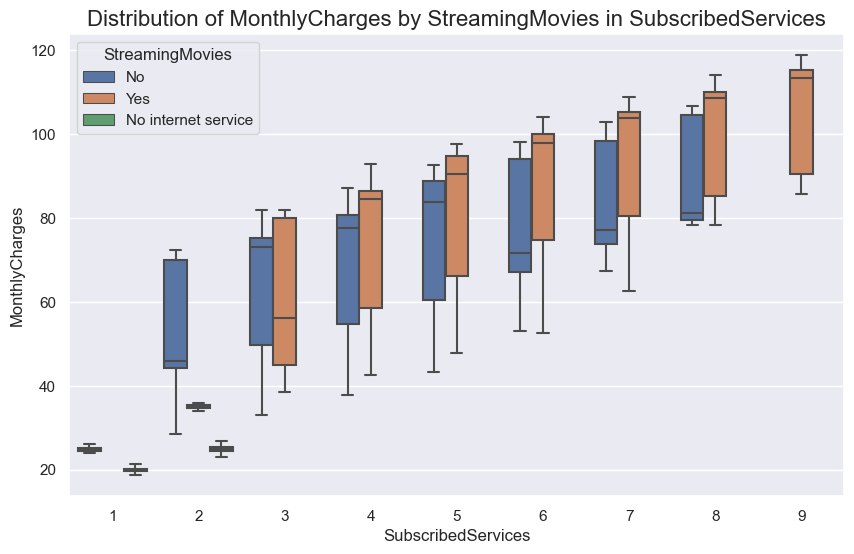

In [862]:
plot_boxplot('StreamingMovies', df)

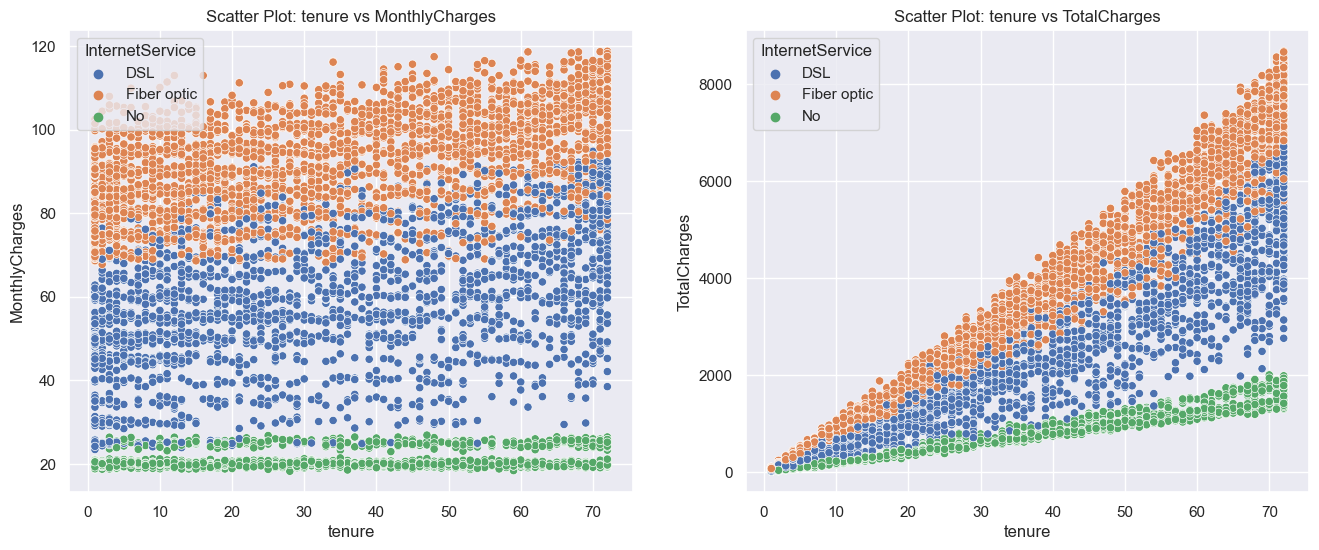

In [863]:
varTenure = 'tenure'
varMonthlyCharges = 'MonthlyCharges'
varTotalCharges = 'TotalCharges'
hue_var = 'InternetService'

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# tenure vs MonthlyCharges
sns.scatterplot(data=df, x=varTenure, y=varMonthlyCharges, hue=hue_var, ax=axes[0])
axes[0].set_title('Scatter Plot: ' + varTenure + ' vs ' + varMonthlyCharges)
axes[0].set_xlabel(varTenure)
axes[0].set_ylabel(varMonthlyCharges)
axes[0].grid(True)

# tenure vs TotalCharges
sns.scatterplot(data=df, x=varTenure, y=varTotalCharges, hue=hue_var, ax=axes[1])
axes[1].set_title('Scatter Plot: '+ varTenure + ' vs ' + varTotalCharges)
axes[1].set_xlabel(varTenure)
axes[1].set_ylabel(varTotalCharges)
axes[1].grid(True)
                  

Text(0.5, 1.0, 'Internet Service vs Churn Rate (%)')

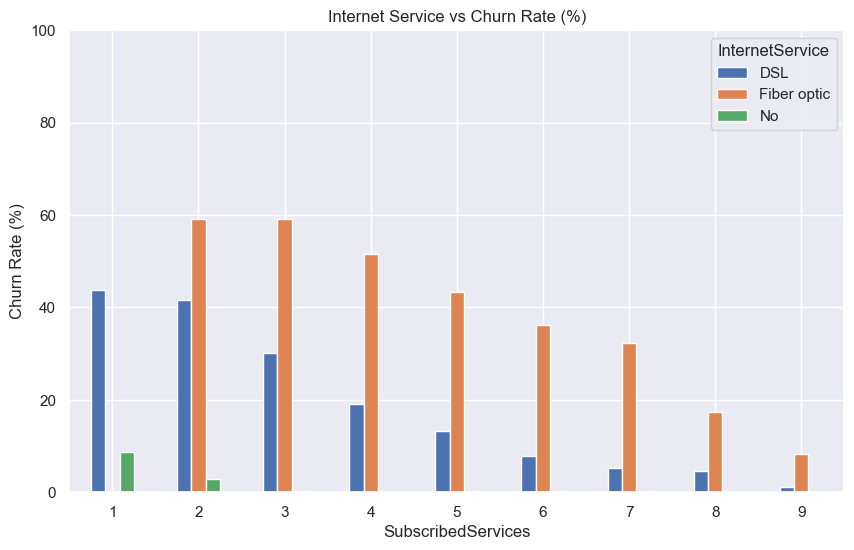

In [864]:
(pd.pivot_table(df, index='SubscribedServices', columns='InternetService', values='Churn', aggfunc='mean')*100).plot(kind='bar', figsize=(10,6))
plt.ylim(0,100)
plt.xticks(rotation=0)
plt.ylabel('Churn Rate (%)')
plt.title('Internet Service vs Churn Rate (%)')

Text(0.5, 1.0, 'Internet Service vs Monthly Charges')

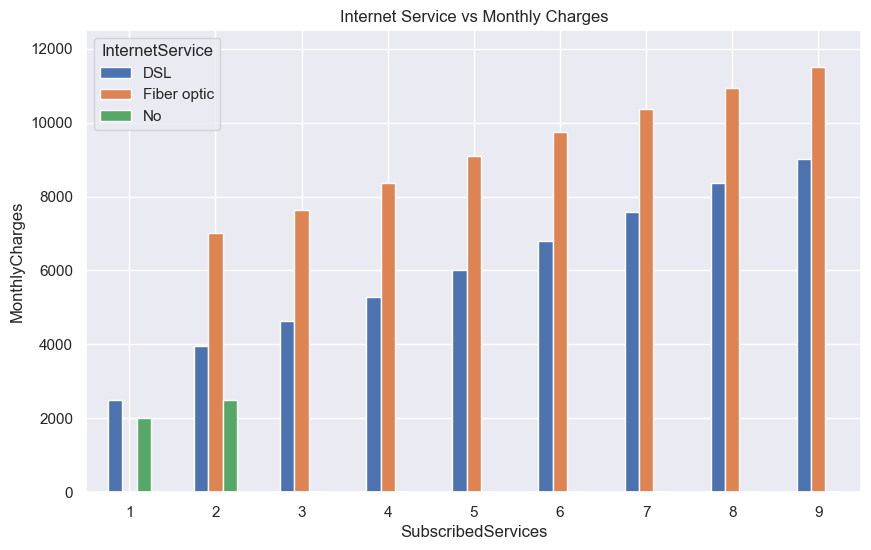

In [865]:
(pd.pivot_table(df, index='SubscribedServices', columns='InternetService', values='MonthlyCharges', aggfunc='mean')*100).plot(kind='bar', figsize=(10,6))
plt.ylim(0, 12500)
plt.xticks(rotation=0)
plt.ylabel('MonthlyCharges')
plt.title('Internet Service vs Monthly Charges')

Text(0.5, 1.0, 'Internet Service vs Total Charges')

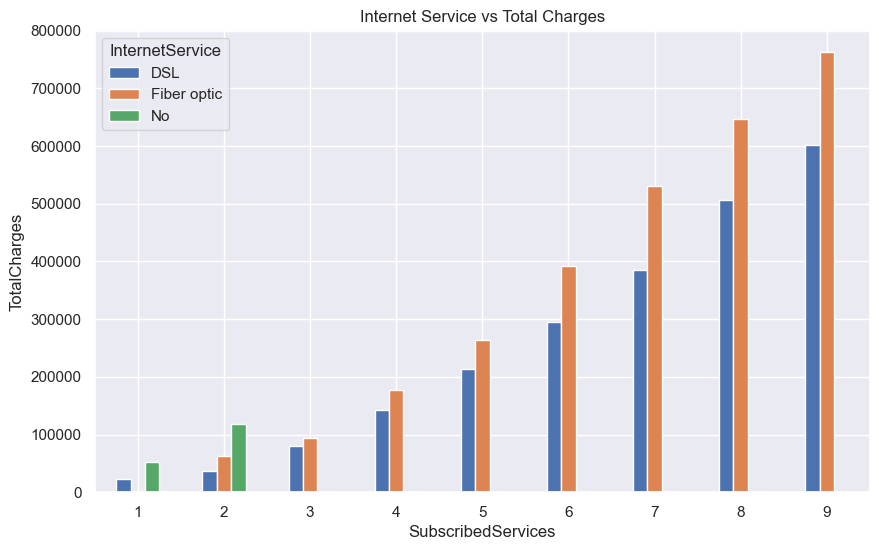

In [866]:
(pd.pivot_table(df, index='SubscribedServices', columns='InternetService', values='TotalCharges', aggfunc='mean')*100).plot(kind='bar', figsize=(10,6))
plt.xticks(rotation=0)
plt.ylabel('TotalCharges')
plt.title('Internet Service vs Total Charges')

#### Observation : 
    The difference on Churn rate is significant with approximately ~15-20% between DSL & Fiber Optic. Even though as customers subscribe to more services, the churn rate drops, but there is still a significant difference in churn rate. Also, based on MonthlyCharges and TotalCharges, even when adding more subscribed services, the price difference is still at a significance. Therefore:

 #### Internet Service Fiber Optic prices influence the impact of Churn rate.

#### 7.3. Do customers with higher tenure tend to choose longer-term Contracts, and how does this impact their churn rate?

In [867]:
print(f'tenure unique :\n {df["tenure"].unique()}\n')
print(f'tenure min : {df["tenure"].unique().min()}\n')
print(f'tenure max : {df["tenure"].unique().max()}\n')

print(f'Contract : {df["Contract"].unique()}\n')

tenure unique :
 [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]

tenure min : 1

tenure max : 72

Contract : ['Month-to-month' 'One year' 'Two year']



#### Observation

  1. Since contract is divided into 3 categories, ranging from Month-to-Month, One year, and Two year. It's best we engineer a new feature grouping the tenure based on the year.

In [868]:
def cat_tenure(tenure):
    if tenure < 13:
        return '0-12 Months'
    elif tenure < 25:
        return '12-24 Months'
    elif tenure < 49:
        return '24-48 Months'
    else:
        return 'Over 48 Months'


In [869]:
new_df['tenureCat'] = new_df['tenure'].apply(cat_tenure)

In [870]:
new_df['tenureCat'].unique()

array(['0-12 Months', '24-48 Months', '12-24 Months', 'Over 48 Months'],
      dtype=object)

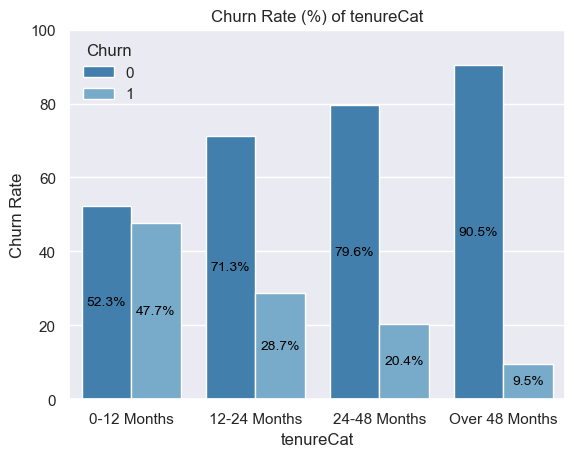

In [871]:
predictor_target(new_df, 'tenureCat')

In [872]:
check_dependency(new_df, 'tenureCat','Churn')

=== V1: tenureCat === V2: Churn ===
Chi-square Statistic : 864.0199735524177 
p-value: 5.638328081483389e-187 < 0.05 
V1 and V2 are dependent (significant association)



Text(0.5, 1.0, 'Tenure vs Contract')

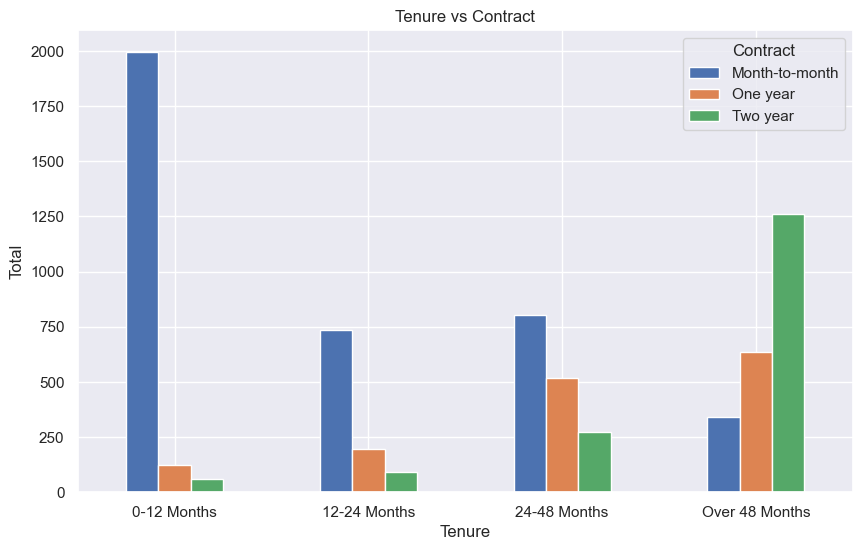

In [873]:
pd.crosstab(new_df['tenureCat'],new_df['Contract']).plot(kind='bar', figsize=(10,6))

plt.xticks(rotation=0)
plt.ylabel('Total',fontsize=12)
plt.xlabel('Tenure',fontsize=12)
plt.title('Tenure vs Contract',fontsize=12)

In [874]:
check_dependency(new_df, 'tenureCat','Contract')

=== V1: tenureCat === V2: Contract ===
Chi-square Statistic : 3160.39544920097 
p-value: 0.0 < 0.05 
V1 and V2 are dependent (significant association)



#### Observation

   1. The more tenure a customer has, the less they tend to churn.
   2. Customers with a tenure of <= 12 months (a year) tend to take a month-to-month Contract. This make sense due to previous findings that customers tend to churn significantly when they take a month-to-month Contract.
   3. Customers with higher tenure do in fact choose a longer-term Contract and they tend to not churn as much.

#### 7.4. What services do customer choose based on the length of their tenure?

In [875]:
def tenure_sub_rate(x, y):
    if y == 'SubscribedServices':
        tenure_count = pd.crosstab(new_df[x], new_df[y]).unstack(level=1).reset_index()
    else:
        tenure_count = pd.crosstab(new_df[x], df[y]).unstack(level=1).reset_index()

    tenure_count.columns = [y, x, 'count']

    tenure_count_df = pd.DataFrame(tenure_count)

    total_customers = tenure_count_df.groupby(x)['count'].sum().reset_index()
    total_customers.columns = [x, 'Total']

    tenure_count_df = tenure_count_df.merge(total_customers, on=x)

    tenure_count_df['Percentage'] = (tenure_count_df['count'] / tenure_count_df['Total']) * 100

    # Pivot the dataframe for plotting
    df_pivot = tenure_count_df.pivot(index=x, columns=y, values='Percentage')

    if y == 'SubscribedServices':
        ax = df_pivot.plot(kind='bar', figsize=(18, 6), width=0.8)
        plt.ylim(0, 30)
        plt.title(f'{y}(%) by {x}')
    else:
        ax = df_pivot.plot(kind='bar', figsize=(10, 6), width=0.8)
        plt.ylim(0, 100)
        plt.title(f'{y} Types (%) by {x}')
    
    
    plt.xlabel(x)
    plt.ylabel('Percentage')
    plt.legend(title=x, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    # Add labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

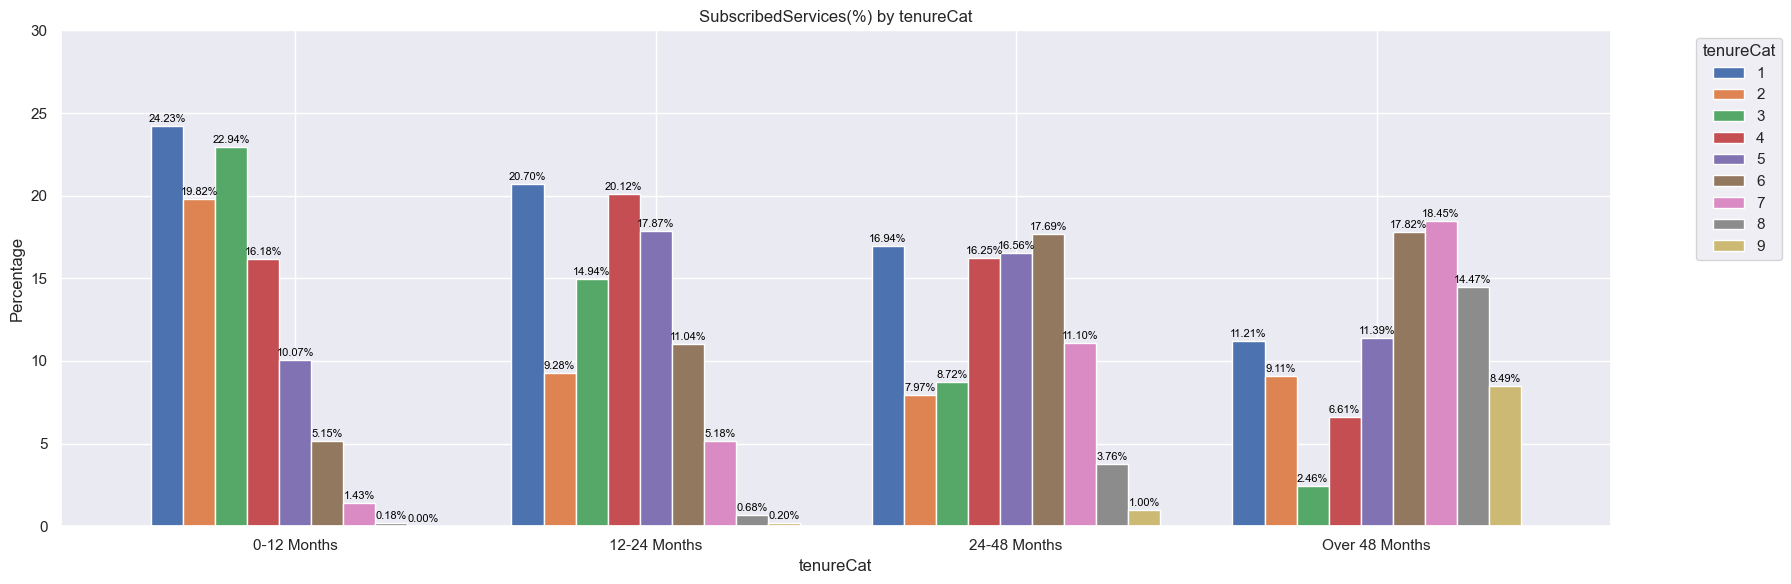

In [876]:
tenure_sub_rate('tenureCat', 'SubscribedServices')


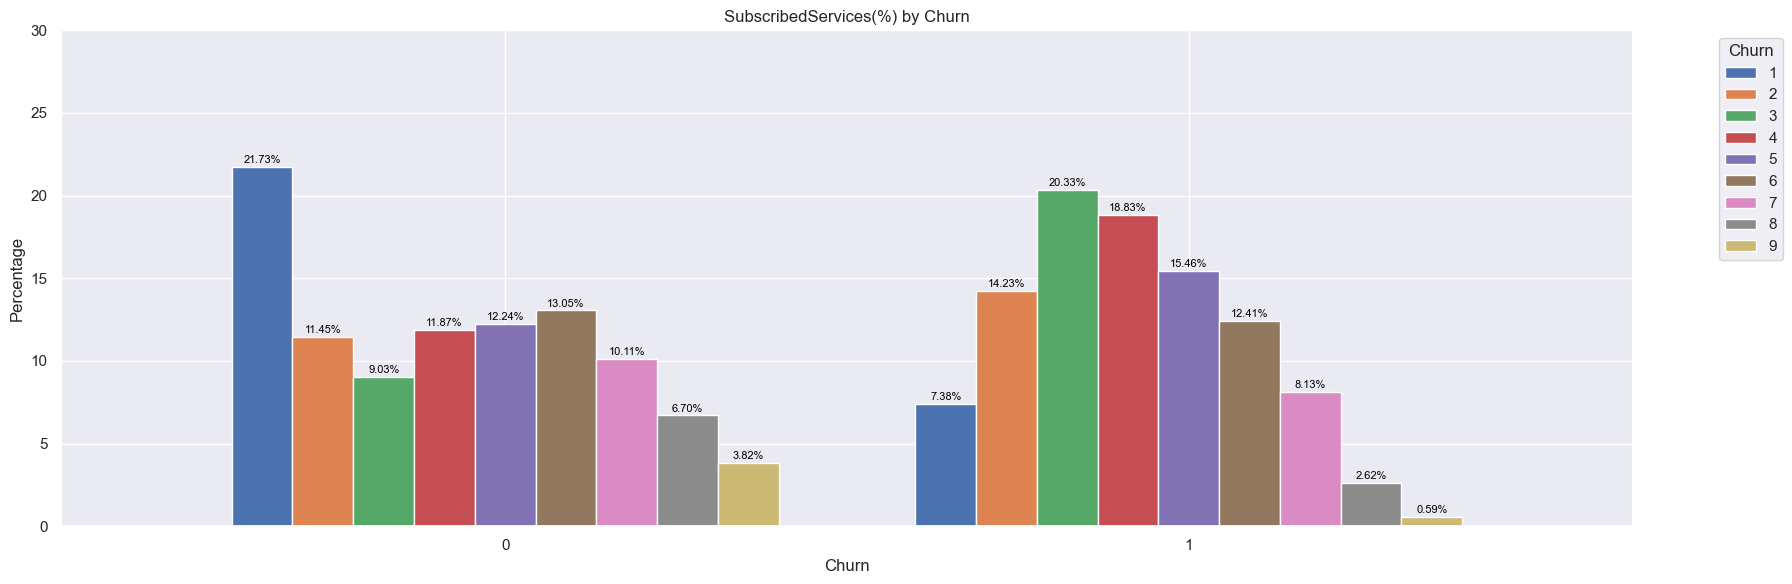

In [877]:
tenure_sub_rate('Churn', 'SubscribedServices')

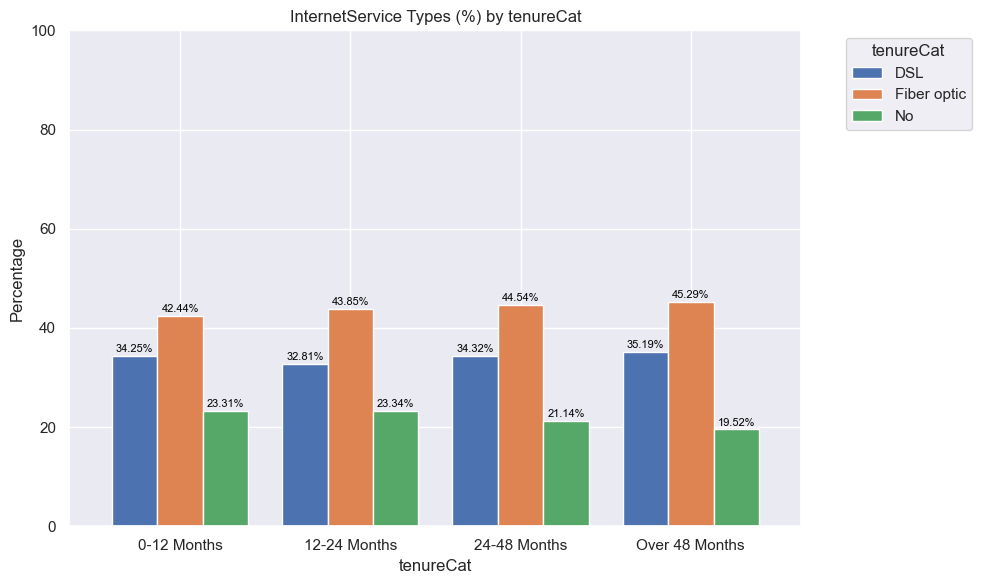

In [878]:
tenure_sub_rate('tenureCat', 'InternetService')

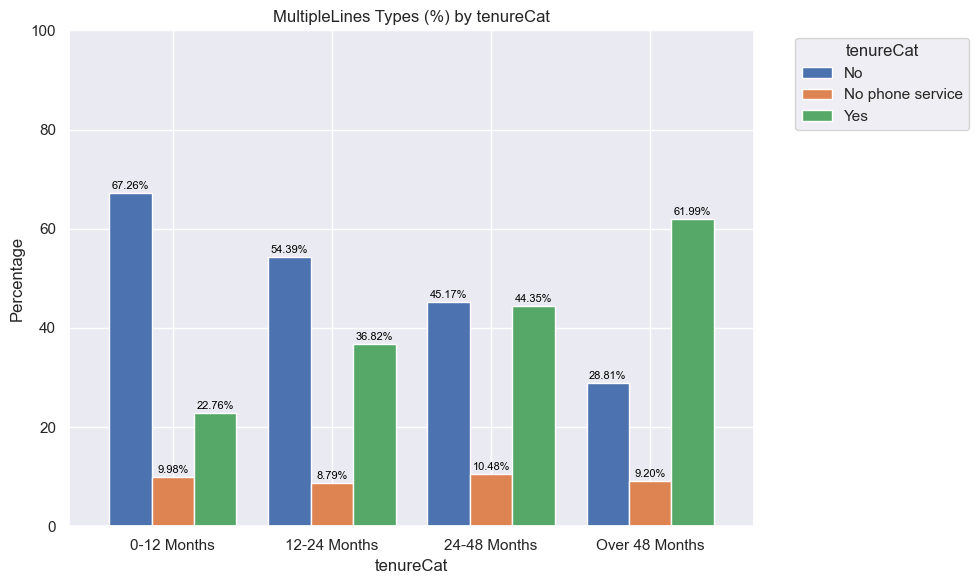

In [879]:
tenure_sub_rate('tenureCat', 'MultipleLines')

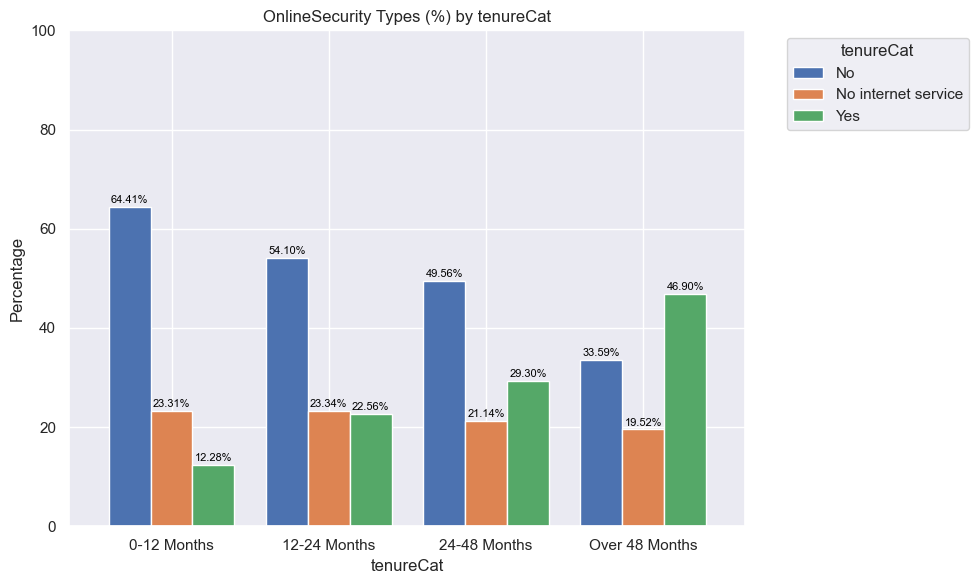

In [880]:
tenure_sub_rate('tenureCat', 'OnlineSecurity')

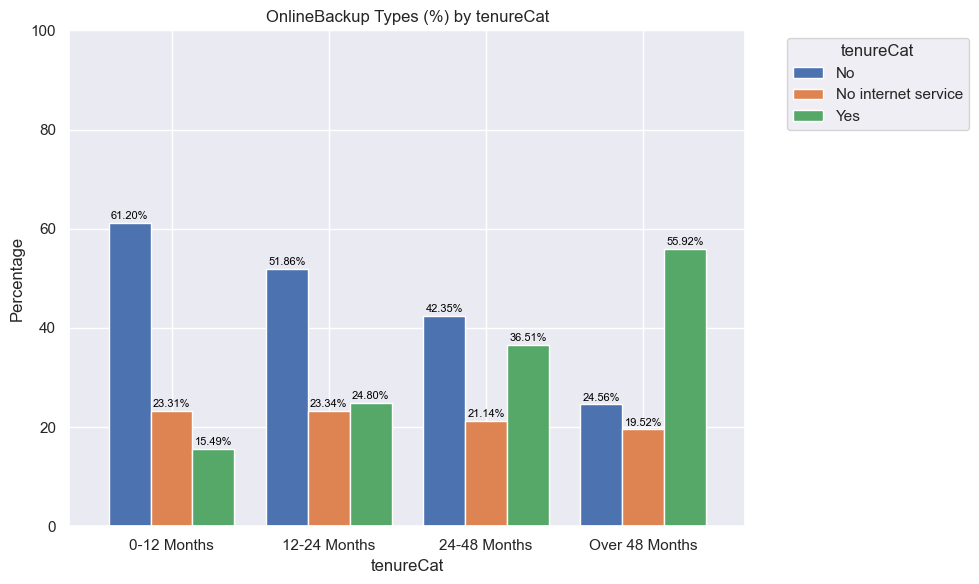

In [881]:
tenure_sub_rate('tenureCat', 'OnlineBackup')

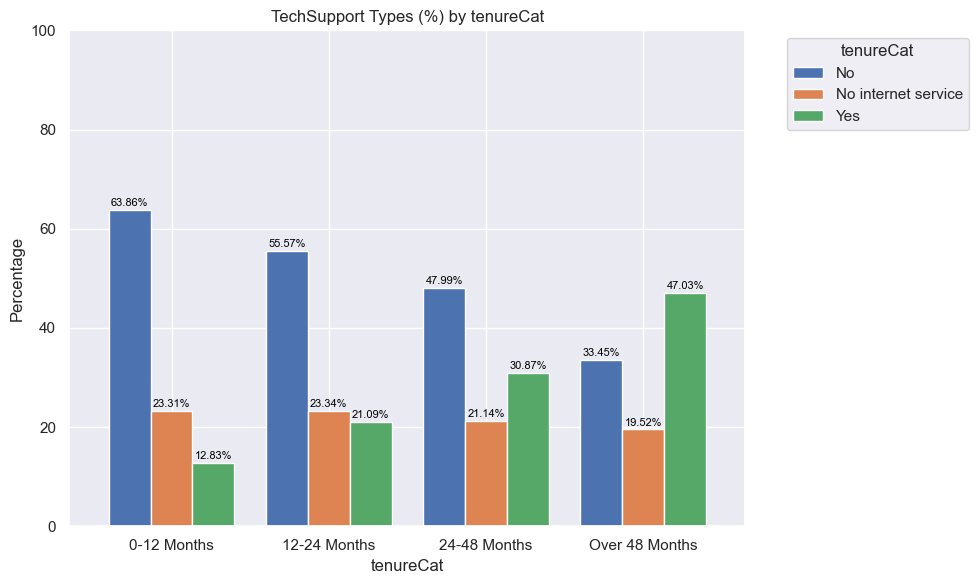

In [882]:
tenure_sub_rate('tenureCat', 'TechSupport')

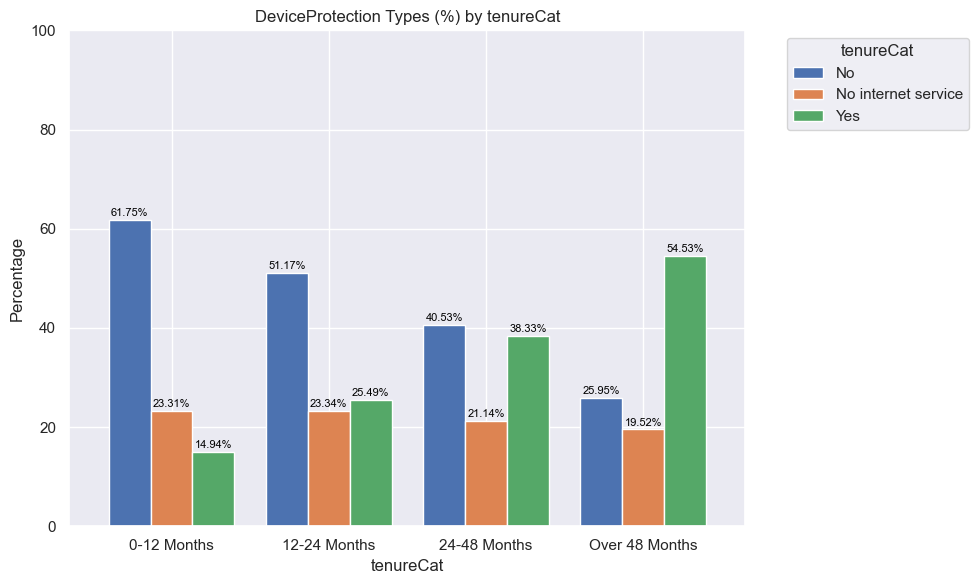

In [883]:
tenure_sub_rate('tenureCat', 'DeviceProtection')

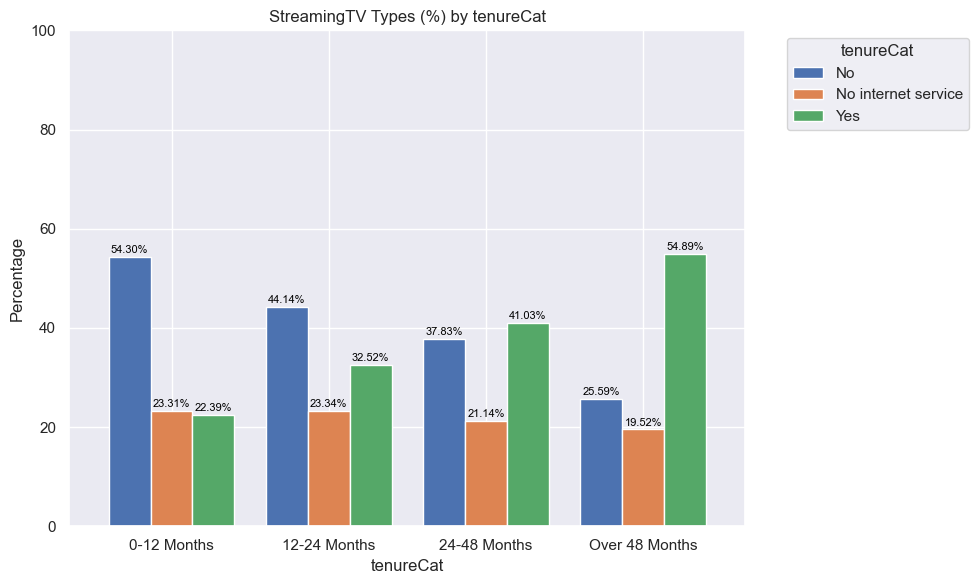

In [884]:
tenure_sub_rate('tenureCat', 'StreamingTV')

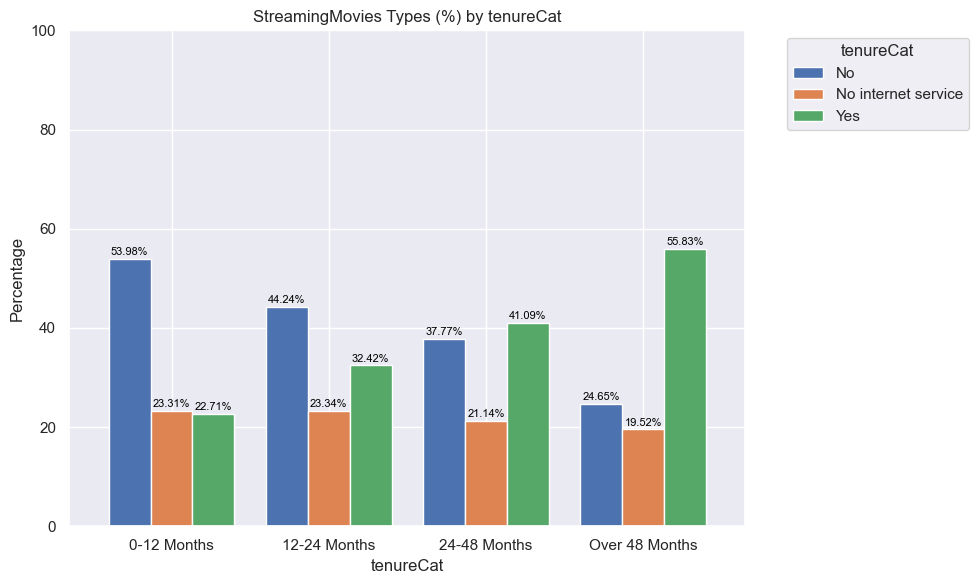

In [885]:
tenure_sub_rate('tenureCat', 'StreamingMovies')

In [886]:
dependentServices = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection']

In [887]:
for i in dependentServices:
    check_dependency(new_df, i, 'tenureCat')

=== V1: MultipleLines === V2: tenureCat ===
Chi-square Statistic : 711.8418178324586 
p-value: 5.678764950448439e-154 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: InternetService === V2: tenureCat ===
Chi-square Statistic : 11.511397435512244 
p-value: 0.009258848147383468 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: OnlineSecurity === V2: tenureCat ===
Chi-square Statistic : 668.761928814464 
p-value: 1.2457075228757717e-144 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: OnlineBackup === V2: tenureCat ===
Chi-square Statistic : 847.8042158090515 
p-value: 1.8546111738494239e-183 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: StreamingMovies === V2: tenureCat ===
Chi-square Statistic : 531.3489733188973 
p-value: 7.664458799290879e-115 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: StreamingTV === V2: tenureCat ===
Chi-square Statistic : 512.4921302601708 
p-value: 9.362169872284552e

#### Observation

   1. The number of services customer subscribes to increases as the tenure increase.
   2. Users tend to churn when they subscribe to 2-5 services.
      
   How many services do customers subscribe to based on tenure?
   1. 0-12 Months : 1 service
   2. 12-24 Months : 1-2 services
   3. 24-48 Months : 1 service or 4-6 services
   4. Over 48 Months : 6-8 services
      
   What do customers tend to subscribe to based on tenure excluding PhoneService?
   1. 0-12 Months : Fiber Optic
   2. 12-24 Months : Fiber Optic, Multiple Lines
   3. 24-48 Months : Fiber Optic, Multiple Lines, StreamingTV, StreamingMovies, Device Protection, OnlineBackup
   4. Over 48 Months : Fiber Optic, Multiple Lines, StreamingTV, StreamingMovies, Device Protection, OnlineBackup, OnlineSecurity, TechSupport

## Data Preparation (Modelling)

#### Feature Selection

In [888]:
data_info(df_ori)

Rows,Columns (7032, 21)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
customerID,0,0.0,object,7032
DeviceProtection,0,0.0,object,3
TotalCharges,0,0.0,float64,6530
MonthlyCharges,0,0.0,float64,1584
PaymentMethod,0,0.0,object,4
PaperlessBilling,0,0.0,object,2
Contract,0,0.0,object,3
StreamingMovies,0,0.0,object,3
StreamingTV,0,0.0,object,3
TechSupport,0,0.0,object,3


Based on Exploratory Data Analysis above, we know that gender and PhoneService do not influence Churn rate. Therefore we drop the two columns so that it doesn't influence our model. We also remove customerID since there's too much unique data and it doesn't effect Churn and the model might be overfitting.

In [889]:
df_model = df_ori.copy()

In [890]:
df_model.drop(['customerID', 'gender', 'PhoneService'], axis=1, inplace=True)

In [891]:
data_info(df_model)

Rows,Columns (7032, 18)
Duplicated Values 41
=====



,missingValue,percentMissing,DataType,Unique
SeniorCitizen,0,0.0,int64,2
Partner,0,0.0,object,2
TotalCharges,0,0.0,float64,6530
MonthlyCharges,0,0.0,float64,1584
PaymentMethod,0,0.0,object,4
PaperlessBilling,0,0.0,object,2
Contract,0,0.0,object,3
StreamingMovies,0,0.0,object,3
StreamingTV,0,0.0,object,3
TechSupport,0,0.0,object,3


In [892]:
# There are 41 duplicates, which is 0.5% of the total data so it's fine if we remove the rows and keep the first
df_model.drop_duplicates(keep = 'first', inplace = True)

In [893]:
data_info(df_model)

Rows,Columns (6991, 18)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
SeniorCitizen,0,0.0,int64,2
Partner,0,0.0,object,2
TotalCharges,0,0.0,float64,6530
MonthlyCharges,0,0.0,float64,1584
PaymentMethod,0,0.0,object,4
PaperlessBilling,0,0.0,object,2
Contract,0,0.0,object,3
StreamingMovies,0,0.0,object,3
StreamingTV,0,0.0,object,3
TechSupport,0,0.0,object,3


#### Note :

Deleting duplicates is necessary so that the model that we want to train is not bias to a certain result.

In [894]:
df_model.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


#### Label Encoding

In [895]:
# Replace 'No' with 0 and 'Yes' with 1 in the 'Partner' column
df_model['Partner'] = df_model['Partner'].replace(['No' ,'Yes'],[0,1])

# Replace 'No' with 0 and 'Yes' with 1 in the 'Dependents' column
df_model['Dependents'] = df_model['Dependents'].replace(['No' ,'Yes'],[0,1])

# Replace 'No' with 0, 'Yes' with 1, and 'No phone service' with 0 in the 'MultipleLines' column
df_model['MultipleLines'] = df_model['MultipleLines'].replace(['No' ,'Yes', 'No phone service'],[0, 1, 0])

# Replace 'No' with 0, 'Fiber optic' with 1, and 'DSL' with 0 in the 'InternetService' column
df_model['InternetService'] = df_model['InternetService'].replace({'No': 0, 'Fiber optic': 2, 'DSL': 1})

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'OnlineSecurity' column
df_model['OnlineSecurity'] = df_model['OnlineSecurity'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'OnlineBackup' column
df_model['OnlineBackup'] = df_model['OnlineBackup'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'DeviceProtection' column
df_model['DeviceProtection'] = df_model['DeviceProtection'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'TechSupport' column
df_model['TechSupport'] = df_model['TechSupport'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'StreamingTV' column
df_model['StreamingTV'] = df_model['StreamingTV'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'StreamingMovies' column
df_model['StreamingMovies'] = df_model['StreamingMovies'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'PaperlessBilling' column
df_model['PaperlessBilling'] = df_model['PaperlessBilling'].replace(['No' ,'Yes'],[0, 1])


#### Ordinal Encoding

In [896]:
Contract_dict = {
    'Month-to-month' : 0,
    'One year' : 1,
    'Two year' : 2}

df_model['Contract'] = df_model['Contract'].map(Contract_dict)

#### One-Hot Encoding

In [897]:
df_model = pd.get_dummies(df_model, columns=['PaymentMethod']).astype(int)

In [898]:
df_model.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,0,1,0,0,...,0,0,1,29,29,0,0,0,1,0
1,0,0,0,34,0,1,1,0,1,0,...,0,1,0,56,1889,0,0,0,0,1
2,0,0,0,2,0,1,1,1,0,0,...,0,0,1,53,108,1,0,0,0,1
3,0,0,0,45,0,1,1,0,1,1,...,0,1,0,42,1840,0,1,0,0,0
4,0,0,0,2,0,2,0,0,0,0,...,0,0,1,70,151,1,0,0,1,0


In [899]:
data_info(df_model)

Rows,Columns (6991, 21)
Duplicated Values 167
=====



,missingValue,percentMissing,DataType,Unique
SeniorCitizen,0,0.0,int32,2
StreamingMovies,0,0.0,int32,2
PaymentMethod_Electronic check,0,0.0,int32,2
PaymentMethod_Credit card (automatic),0,0.0,int32,2
PaymentMethod_Bank transfer (automatic),0,0.0,int32,2
Churn,0,0.0,int32,2
TotalCharges,0,0.0,int32,3846
MonthlyCharges,0,0.0,int32,99
PaperlessBilling,0,0.0,int32,2
Contract,0,0.0,int32,3


In [900]:
# There are 167 duplicates, which is 2.3% of the total data after encoding (6991) so it's fine if we remove the rows and keep the first
df_model.drop_duplicates(keep = 'first', inplace = True)

In [901]:
data_info(df_model)


Rows,Columns (6824, 21)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
SeniorCitizen,0,0.0,int32,2
StreamingMovies,0,0.0,int32,2
PaymentMethod_Electronic check,0,0.0,int32,2
PaymentMethod_Credit card (automatic),0,0.0,int32,2
PaymentMethod_Bank transfer (automatic),0,0.0,int32,2
Churn,0,0.0,int32,2
TotalCharges,0,0.0,int32,3846
MonthlyCharges,0,0.0,int32,99
PaperlessBilling,0,0.0,int32,2
Contract,0,0.0,int32,3


#### Data Sampling

In [902]:
df_model['Churn'].value_counts()

Churn
0    5069
1    1755
Name: count, dtype: int64

In [903]:
df_model['Churn'].value_counts(normalize=True)

Churn
0    0.742819
1    0.257181
Name: proportion, dtype: float64

In [904]:
# feature
X = df_model.drop(['Churn'],axis=1)

# target
y = df_model['Churn']

We use oversampling method to populate the Churn rate

In [905]:
X_over_smote, y_over_smote = SMOTE().fit_resample(X, y)

In [906]:
X_train, X_test, y_train, y_test = train_test_split(X_over_smote, y_over_smote, test_size=0.2, random_state=42)

In [954]:
#### Feature Transformation

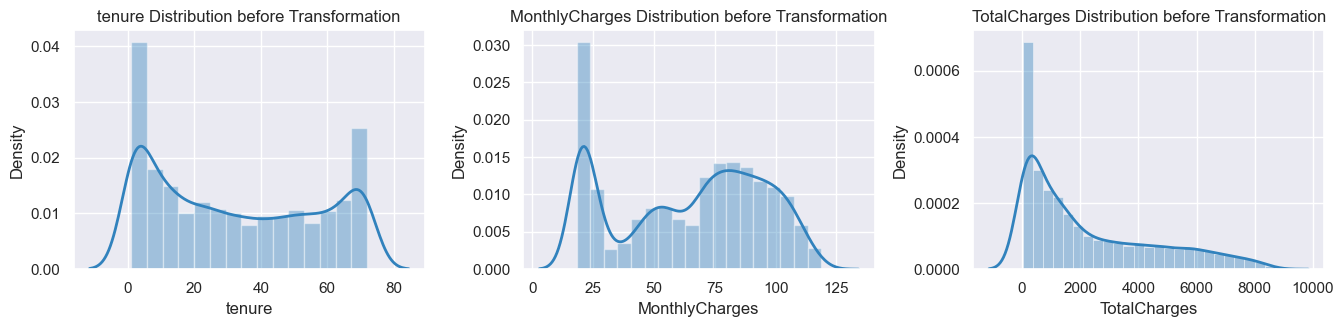

In [907]:
plt.figure(figsize=(18,6))
for i in range(0, len(customerSpending)):
  plt.subplot(2, 4, i+1)

  sns.histplot(x=df[customerSpending[i]], hue = i, palette = "tab20c", 
               legend=False, kde=True, stat="density", line_kws={'linewidth': 2}, 
               kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
  
  plt.title(f'{customerSpending[i]} Distribution before Transformation')
  plt.xlabel(customerSpending[i])
  plt.tight_layout()

tenure and MonthlyCharges are evenly distributed, TotalCharges on the other hand is positively skewed.

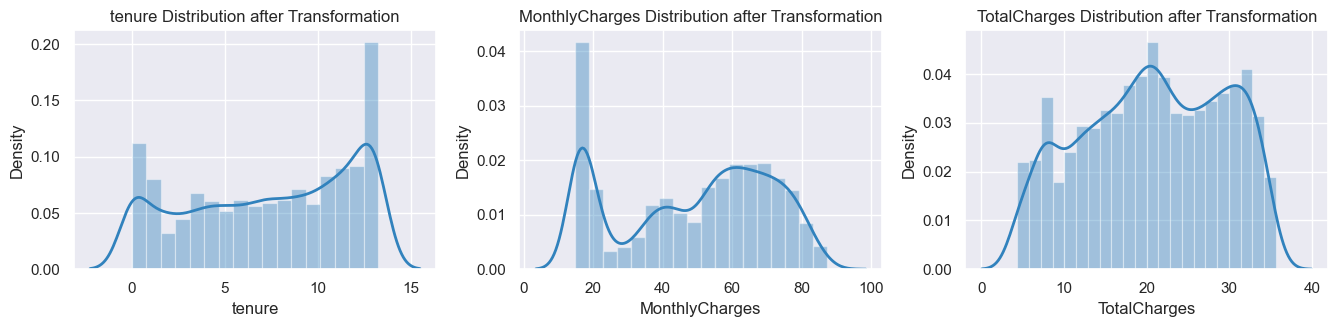

In [908]:
plt.figure(figsize=(18,6))
for i in range(0, len(customerSpending)):
  plt.subplot(2, 4, i+1)

  fitted_data, fitted_lambda = stats.boxcox(df[customerSpending[i]])

  sns.histplot(x=fitted_data, hue = i, palette = "tab20c", 
               legend=False, kde=True, stat="density", line_kws={'linewidth': 2}, 
               kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
  
  plt.title(f'{customerSpending[i]} Distribution after Transformation')
  plt.xlabel(customerSpending[i])
  plt.tight_layout()

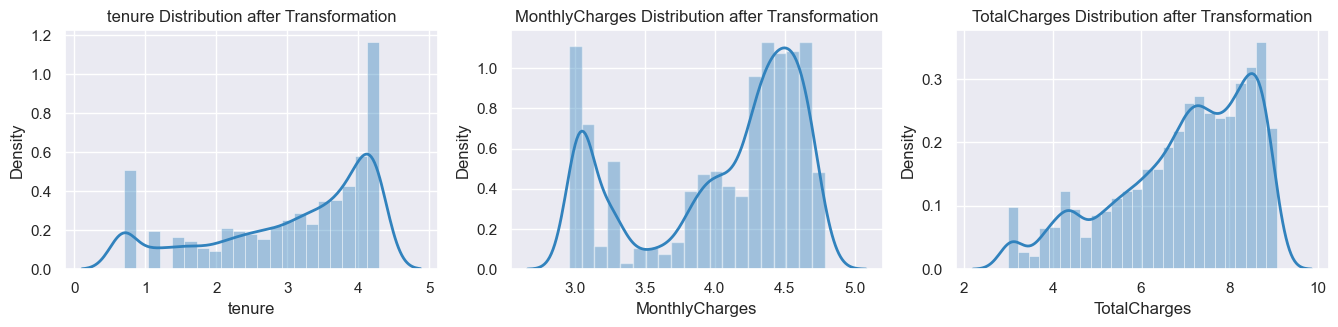

In [909]:
plt.figure(figsize=(18,6))
for i in range(0, len(customerSpending)):
  plt.subplot(2, 4, i+1)

  sns.histplot(x=np.log1p(df[customerSpending[i]]), hue = i, palette = "tab20c", 
               legend=False, kde=True, stat="density", line_kws={'linewidth': 2}, 
               kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
  
  plt.title(f'{customerSpending[i]} Distribution after Transformation')
  plt.xlabel(customerSpending[i])
  plt.tight_layout()


log1p is chosen due to the fact TotalCharges has wide data spread. For tenure and MonthlyCharges we use non transformed data since after transformation the distribution is similar.

In [910]:
X_train['TotalCharges'] = np.log1p(X_train['TotalCharges'])

In [911]:
X_test['TotalCharges'] = np.log1p(X_test['TotalCharges'])

#### Feature Scalling

In [912]:
scaler = preprocessing.StandardScaler()

In [913]:
X_train_std = scaler.fit_transform(X_train)

In [914]:
X_train_std

array([[-0.39069623,  1.25288008, -0.53409876, ..., -0.42504913,
        -0.72734771, -0.44747826],
       [ 2.55953324, -0.79816099, -0.53409876, ..., -0.42504913,
        -0.72734771, -0.44747826],
       [-0.39069623,  1.25288008, -0.53409876, ..., -0.42504913,
        -0.72734771, -0.44747826],
       ...,
       [-0.39069623,  1.25288008, -0.53409876, ..., -0.42504913,
        -0.72734771, -0.44747826],
       [-0.39069623, -0.79816099,  1.87231289, ..., -0.42504913,
        -0.72734771, -0.44747826],
       [-0.39069623, -0.79816099, -0.53409876, ..., -0.42504913,
        -0.72734771, -0.44747826]])

In [915]:
X_test_std = scaler.fit_transform(X_test)

In [916]:
X_test_std

array([[-0.4101253 , -0.79304203, -0.51873534, ..., -0.43685203,
         1.39866659, -0.43364641],
       [ 2.4382792 ,  1.26096721, -0.51873534, ...,  2.28910463,
        -0.71496668, -0.43364641],
       [-0.4101253 ,  1.26096721, -0.51873534, ..., -0.43685203,
        -0.71496668, -0.43364641],
       ...,
       [-0.4101253 , -0.79304203, -0.51873534, ..., -0.43685203,
         1.39866659, -0.43364641],
       [-0.4101253 , -0.79304203, -0.51873534, ..., -0.43685203,
        -0.71496668,  2.30602624],
       [-0.4101253 , -0.79304203, -0.51873534, ..., -0.43685203,
        -0.71496668, -0.43364641]])

In [917]:
X_train.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
7605,0,1,0,66,1,1,0,0,1,0,1,1,2,1,79,8.569026,0,0,0,0
8049,1,0,0,2,1,2,0,0,0,0,0,0,0,0,87,5.068904,0,0,0,0
9446,0,1,0,59,1,1,0,1,0,0,1,0,0,1,89,8.565793,0,0,0,0
2684,0,0,0,64,1,2,0,0,1,1,1,1,1,1,104,8.837826,0,1,0,0
9404,0,0,0,9,1,2,0,0,0,0,0,0,0,0,93,6.756932,0,0,0,0


In [918]:
y_train.head()

7605    1
8049    1
9446    1
2684    0
9404    1
Name: Churn, dtype: int32

## Modelling

#### Logistic Regression

In [919]:
logreg = LogisticRegression(random_state=42)

Confusion Matrix : 
[[3412  646]
 [ 605 3447]]

 Accuracy : 0.8457459926017262
 Recall Score : 0.8506910167818361
 Precision Score : 0.8421695577815783
 F1 Score : 0.8464088397790055
 ROC-AUC Score : 0.9259909800002627

 Recall scores for each fold: [0.8298397  0.8458693  0.85679012 0.8617284  0.84814815]
 Average recall score: 0.8484751335799425


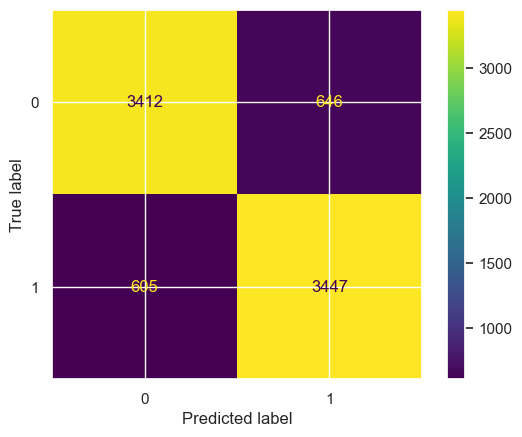

In [920]:
train_eval(X_train_std, y_train, logreg)

Confusion Matrix : 
[[860 151]
 [163 854]]

 Accuracy : 0.8451676528599605
 Recall Score : 0.839724680432645
 Precision Score : 0.8497512437810946
 F1 Score : 0.8447082096933729
 ROC-AUC Score : 0.9227961450592159


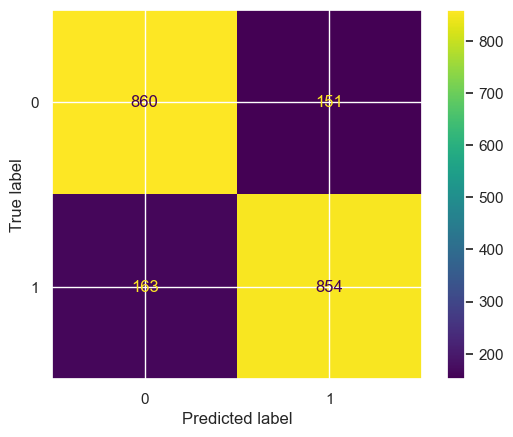

In [921]:
test_eval(X_test_std, y_test, logreg)

#### K-Nearest Neighbor

In [922]:
knn = KNeighborsClassifier()

Confusion Matrix : 
[[3525  533]
 [ 466 3586]]

 Accuracy : 0.8768187422934649
 Recall Score : 0.8849950641658441
 Precision Score : 0.8705996601116776
 F1 Score : 0.8777383429200832
 ROC-AUC Score : 0.9533803895830303

 Recall scores for each fold: [0.8162762  0.81750925 0.8382716  0.84320988 0.83580247]
 Average recall score: 0.8302138801357873


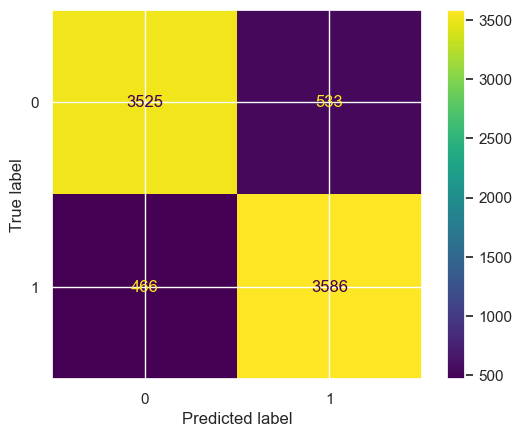

In [923]:
train_eval(X_train_std, y_train, knn)

Confusion Matrix : 
[[821 190]
 [184 833]]

 Accuracy : 0.8155818540433925
 Recall Score : 0.8190757128810227
 Precision Score : 0.8142717497556208
 F1 Score : 0.8166666666666668
 ROC-AUC Score : 0.8892691699078086


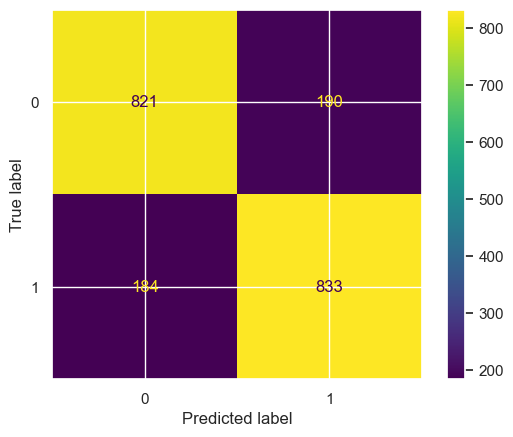

In [924]:
test_eval(X_test_std, y_test, knn)

#### Decision Tree

In [925]:
dt = DecisionTreeClassifier(random_state=42)

Confusion Matrix : 
[[4037   21]
 [  10 4042]]

 Accuracy : 0.996177558569667
 Recall Score : 0.9975320829220138
 Precision Score : 0.9948314053654935
 F1 Score : 0.9961799137399876
 ROC-AUC Score : 0.9999509518205175

 Recall scores for each fold: [0.80641184 0.79778052 0.81728395 0.82962963 0.8037037 ]
 Average recall score: 0.8109619278135514


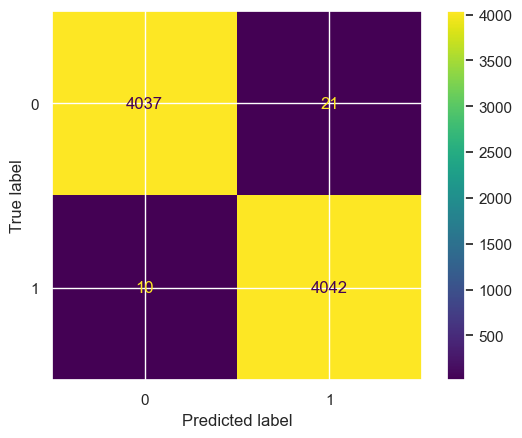

In [926]:
train_eval(X_train_std, y_train, dt)

Confusion Matrix : 
[[782 229]
 [239 778]]

 Accuracy : 0.7692307692307693
 Recall Score : 0.7649950835791544
 Precision Score : 0.7725918570009931
 F1 Score : 0.7687747035573124
 ROC-AUC Score : 0.7705947458973902


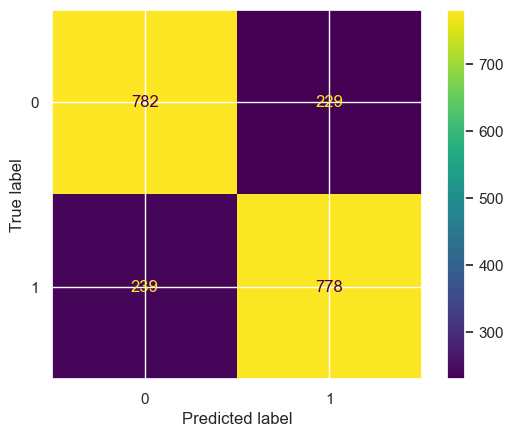

In [927]:
test_eval(X_test_std, y_test, dt)

#### Random Forest

In [928]:
rf = RandomForestClassifier(random_state=42)

Confusion Matrix : 
[[4028   30]
 [   1 4051]]

 Accuracy : 0.996177558569667
 Recall Score : 0.9997532082922014
 Precision Score : 0.9926488605733889
 F1 Score : 0.9961883683757531
 ROC-AUC Score : 0.9995127110500895

 Recall scores for each fold: [0.83847102 0.83107275 0.85185185 0.85679012 0.84938272]
 Average recall score: 0.845513692895526


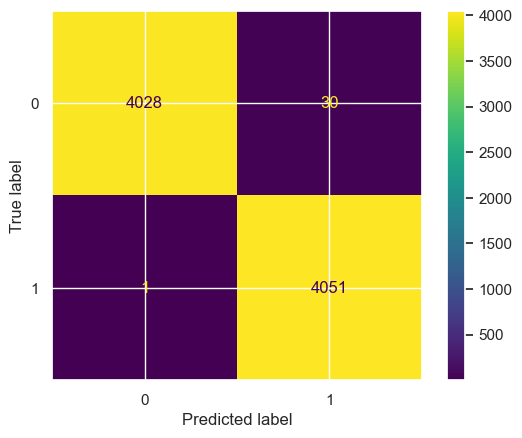

In [929]:
train_eval(X_train_std, y_train, rf)

Confusion Matrix : 
[[857 154]
 [164 853]]

 Accuracy : 0.8431952662721893
 Recall Score : 0.8387413962635202
 Precision Score : 0.8470705064548163
 F1 Score : 0.842885375494071
 ROC-AUC Score : 0.9200592888258654


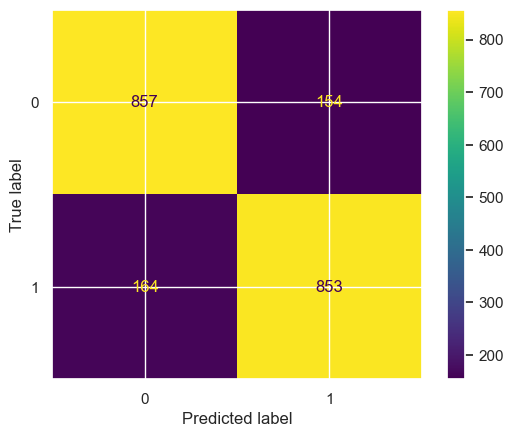

In [930]:
test_eval(X_test_std, y_test, rf)

#### Naive Bayes

In [937]:
nb = GaussianNB()

Confusion Matrix : 
[[3217  841]
 [ 722 3330]]

 Accuracy : 0.8072749691738594
 Recall Score : 0.8218163869693978
 Precision Score : 0.7983696955166627
 F1 Score : 0.8099233856256841
 ROC-AUC Score : 0.8843940491209153

 Recall scores for each fold: [0.80394575 0.8162762  0.8345679  0.82962963 0.81975309]
 Average recall score: 0.8208345130992069


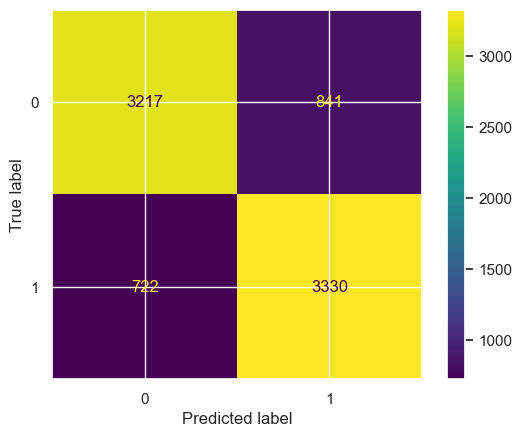

In [938]:
train_eval(X_train_std, y_train, nb)

## Evaluation

Since we are basing Churn as the target variable, we prioritize in looking how consistent the recall score of each model trained and tested. Based on the modelling process, we found out that Naive Bayes has the closest recall score percentage when compared between train and test data.

## Conclusion
   Model that will be used for predicting future Telco-Churn data is Naive Baye.

import pickle

In [934]:
with open('csi_project.pkl', 'wb') as file:
    pickle.dump(rf, file)